Fillers:
- Synthetic dataset
- IDW
- IterativeImputer 

In [10]:
#generate synthtic dataset
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm # Import cm for colormap handling
from scipy.ndimage import gaussian_filter # For smoothing features
from matplotlib.colors import ListedColormap, Normalize # For custom colormap for classes and normalization

def simulate_complex_dem(shape=(256, 256)):
    """
    Simulates a digital elevation model (DEM) for a complex environment
    including urban areas, trees, parks, forest, roads, river, lake,
    football field, bare elevations, and new bare earth clearings within
    urban and forest zones.

    Args:
        shape (tuple): The desired shape of the DEM grid (height, width).

    Returns:
        tuple: A tuple containing:
            - X (numpy.ndarray): The x-coordinates of the grid.
            - Y (numpy.ndarray): The y-coordinates of the grid.
            - Z_scaled (numpy.ndarray): A 2D array representing the urban DEM, values scaled 0-255.
            - class_mask (numpy.ndarray): A 2D array representing the class labels for each pixel.
    """
    height, width = shape
    x = np.linspace(0, 1, width)
    y = np.linspace(0, 1, height)
    X, Y = np.meshgrid(x, y)

    # Initialize Z (elevation) and class_mask
    Z = np.zeros(shape, dtype=np.float32)
    # Initialize with -1 for unassigned, will be overwritten by specific classes
    class_mask = np.full(shape, -1, dtype=np.int32)

    # Define class labels for the mask
    # Using 0 for bare elevation and subsequent integers for other features.
    CLASS_BARE_ELEVATION = 0
    CLASS_URBAN = 1
    CLASS_TREES = 2
    CLASS_PARK = 3
    CLASS_FOREST = 4
    CLASS_ROAD = 5
    CLASS_RIVER = 6
    CLASS_LAKE = 7
    CLASS_FOOTBALL_FIELD = 8

    # --- Bare Elevations (Base Terrain) ---
    # Gentle slopes using sine and cosine waves for the base elevation.
    Z = 50 * (np.sin(X * 4 * np.pi) + np.cos(Y * 3 * np.pi))
    # Assign bare elevation to all pixels initially, will be overwritten by other features
    class_mask[Z > -np.inf] = CLASS_BARE_ELEVATION
    # Add some general random noise for a more natural look on bare ground.
    Z += np.random.normal(0, 5, size=shape)

    # --- Urban Areas ---
    # Simulate multiple "building" like structures using Gaussian peaks.
    urban_areas_mask = np.zeros(shape, dtype=bool)
    building_coords = [(0.25, 0.26), (0.7, 0.75), (0.4, 0.6), (0.8, 0.09)]
    building_heights = [150, 180, 120, 10]
    building_scales = [0.03, 0.05, 0.02, 0.04] # Controls sharpness/spread of buildings

    for (bx, by), bh, bs in zip(building_coords, building_heights, building_scales):
        building_shape = np.exp(-((X - bx)**2 + (Y - by)**2) / bs)
        # Add height only where the building shape is significant
        Z[building_shape > 0.1] += building_shape[building_shape > 0.1] * bh
        urban_areas_mask[building_shape > 0.1] = True # Mark pixels as urban

    # Apply a slight Gaussian filter to urban areas for smoother transitions
    # This helps in creating plateaus or large blocks rather than sharp points.
    Z[urban_areas_mask] = gaussian_filter(Z[urban_areas_mask], sigma=1.5)
    class_mask[urban_areas_mask] = CLASS_URBAN

    # --- River ---
    # Create a winding river path.
    river_width = 0.02
    river_path_y = 0.5 + 0.2 * np.sin(X * 2 * np.pi + Y * np.pi) # Sine wave for winding path
    river_mask = np.abs(Y - river_path_y) < river_width
    # Set river elevation to a low, relatively flat value.
    Z[river_mask] = np.random.uniform(10, 30, size=Z[river_mask].shape)
    class_mask[river_mask] = CLASS_RIVER
    # Smooth river edges slightly for a natural look.
    Z[river_mask] = gaussian_filter(Z[river_mask], sigma=0.5)

    # --- Lake ---
    # Create a roughly circular lake.
    lake_center_x, lake_center_y = 0.6, 0.3
    lake_radius = 0.1
    lake_dist = np.sqrt((X - lake_center_x)**2 + (Y - lake_center_y)**2)
    lake_mask = lake_dist < lake_radius
    # Set lake elevation to be very low and flat.
    Z[lake_mask] = np.random.uniform(5, 25, size=Z[lake_mask].shape)
    class_mask[lake_mask] = CLASS_LAKE
    # Ensure lake is perfectly flat for realism.
    Z[lake_mask] = Z[lake_mask].mean()

    # --- Roads ---
    # Define a couple of intersecting roads and a diagonal one.
    road_width = 0.01
    road1_mask = np.abs(Y - 0.4) < road_width
    road2_mask = np.abs(X - 0.5) < road_width
    # Diagonal road example
    road3_mask = np.abs(Y - (0.1 + 0.2 * X)) < road_width * 1.5
    road_mask = road1_mask | road2_mask | road3_mask

    # Prioritize roads over existing features (e.g., bare elevation) where they overlap.
    # Roads are set to a mid-range flat elevation.
    Z[road_mask] = np.random.uniform(50, 70, size=Z[road_mask].shape)
    class_mask[road_mask] = CLASS_ROAD
    # Smooth roads to ensure they are flat.
    Z[road_mask] = gaussian_filter(Z[road_mask], sigma=0.5)

    # --- Football Field ---
    # Define a rectangular area for a football field.
    field_center_x, field_center_y = 0.4, 0.8
    field_width, field_height = 0.1, 0.07
    field_mask = (X > field_center_x - field_width/2) & (X < field_center_x + field_width/2) & \
                 (Y > field_center_y - field_height/2) & (Y < field_center_y + field_height/2)

    # Ensure football field is flat and at a typical "ground" level.
    Z[field_mask] = np.random.uniform(60, 80, size=Z[field_mask].shape)
    class_mask[field_mask] = CLASS_FOOTBALL_FIELD
    Z[field_mask] = Z[field_mask].mean() # Make it perfectly flat

    # --- Parks (flat green spaces) ---
    # Define a circular park area.
    park_center_x, park_center_y = 0.7, 0.4
    park_radius = 0.2
    park_dist = np.sqrt((X - park_center_x)**2 + (Y - park_center_y)**2)
    park_mask = park_dist < park_radius

    # Assign parks only where not already taken by more dominant features (roads, urban, water bodies).
    # Check if the existing class is bare elevation before assigning park.
    can_be_park = (class_mask == CLASS_BARE_ELEVATION)
    park_mask = park_mask & can_be_park
    Z[park_mask] = np.random.uniform(80, 100, size=Z[park_mask].shape) # Slightly elevated from base
    class_mask[park_mask] = CLASS_PARK
    Z[park_mask] = gaussian_filter(Z[park_mask], sigma=1.0) # Smooth park topography

    # --- Forest Areas (dense trees) ---
    # Define a large rectangular forest block.
    forest_mask = (X > 0.1) & (X < 0.4) & (Y > 0.6) & (Y < 0.9)

    # Only assign forest to areas that are currently bare elevation.
    can_be_forest = (class_mask == CLASS_BARE_ELEVATION)
    forest_mask = forest_mask & can_be_forest
    # Add height for trees in the forest.
    Z[forest_mask] += np.random.uniform(20, 50, size=Z[forest_mask].shape)
    class_mask[forest_mask] = CLASS_FOREST
    Z[forest_mask] = gaussian_filter(Z[forest_mask], sigma=2.0) # Smooth forest topography

    # --- Individual Trees (scattered) ---
    # Add small, distinct elevated bumps for individual trees.
    num_trees = 129
    for _ in range(num_trees):
        tx, ty = np.random.uniform(0, 1), np.random.uniform(0, 1)
        tree_radius = 0.005 # Small radius for individual trees
        tree_height = np.random.uniform(10, 30) # Small height for the bump
        tree_dist = np.sqrt((X - tx)**2 + (Y - ty)**2)
        tree_spot_mask = tree_dist < tree_radius
        # Only place trees where it's bare elevation or park, not on buildings, water, or roads.
        can_be_tree = (class_mask == CLASS_BARE_ELEVATION) | (class_mask == CLASS_PARK)
        tree_spot_mask = tree_spot_mask & can_be_tree
        Z[tree_spot_mask] += tree_height # Add a small elevation bump
        class_mask[tree_spot_mask] = CLASS_TREES

    # --- Add Batches of Bare Earth (Clearings/Undeveloped) within Urban and Forest Areas ---
    num_clearings_urban = 23 # Number of bare earth patches in urban areas
    clearing_size_urban_min = 0.03 # Min relative size of urban clearings
    clearing_size_urban_max = 0.06 # Max relative size of urban clearings

    num_clearings_forest = 8 # Number of bare earth patches in forest areas
    clearing_size_forest_min = 0.05 # Min relative size of forest clearings
    clearing_size_forest_max = 0.1 # Max relative size of forest clearings

    # Function to add clearings
    def add_clearings(target_mask, num_clearings, min_size, max_size):
        valid_indices = np.argwhere(target_mask)
        if valid_indices.size == 0:
            return

        for _ in range(num_clearings):
            # Choose a random center within the target area
            center_idx = valid_indices[np.random.randint(0, len(valid_indices))]
            center_y, center_x = center_idx[0], center_idx[1]

            # Convert pixel coordinates to normalized (0-1) coordinates
            norm_cx = center_x / width
            norm_cy = center_y / height

            # Randomize clearing size
            clearing_size = np.random.uniform(min_size, max_size)

            # Create a circular mask for the clearing
            clearing_dist = np.sqrt((X - norm_cx)**2 + (Y - norm_cy)**2)
            clearing_mask = clearing_dist < clearing_size

            # Ensure clearing is only placed within the target_mask and not on existing water/roads
            can_be_clearing = clearing_mask & target_mask & \
                              (class_mask != CLASS_RIVER) & (class_mask != CLASS_LAKE) & \
                              (class_mask != CLASS_ROAD) & (class_mask != CLASS_FOOTBALL_FIELD)

            # Apply bare earth elevation and class to the clearing area
            Z[can_be_clearing] = np.random.uniform(50, 80, size=Z[can_be_clearing].shape) # Mid-range bare earth elevation
            class_mask[can_be_clearing] = CLASS_BARE_ELEVATION
            Z[can_be_clearing] = gaussian_filter(Z[can_be_clearing], sigma=1.0) # Smooth clearing

    # Add bare earth clearings to urban areas
    add_clearings(urban_areas_mask, num_clearings_urban, clearing_size_urban_min, clearing_size_urban_max)

    # Add bare earth clearings to forest areas
    add_clearings(forest_mask, num_clearings_forest, clearing_size_forest_min, clearing_size_forest_max)

    # Final scaling of Z values to fit within 0-255 for visualization.
    Z_min, Z_max = Z.min(), Z.max()
    if Z_max - Z_min == 0:
        Z_scaled = np.zeros(shape, dtype=np.float32)
    else:
        Z_scaled = 255 * (Z - Z_min) / (Z_max - Z_min)

    # Return X, Y coordinates, the scaled DEM, and the class mask.
    return X, Y, Z_scaled.astype(np.float32), class_mask

def create_grid_with_gaps(base_grid, block_size=(8, 8), num_blocks=20):
    """
    Creates a copy of the base grid and inserts randomly placed 'gaps' (blocks of NaNs).
    These NaNs will be masked and plotted in black.

    Args:
        base_grid (numpy.ndarray): The initial DEM grid.
        block_size (tuple): The size of each gap block (block_height, block_width).
        num_blocks (int): The number of gap blocks to insert.

    Returns:
        numpy.ma.MaskedArray: The grid with the specified gaps, where gaps are masked.
    """
    grid_with_gaps = base_grid.copy()

    grid_height, grid_width = base_grid.shape
    block_height, block_width = block_size

    for _ in range(num_blocks):
        # Ensure the block fully fits within the grid boundaries.
        if grid_height - block_height < 0 or grid_width - block_width < 0:
            continue # Skip if block is larger than grid
        start_y = np.random.randint(0, grid_height - block_height + 1)
        start_x = np.random.randint(0, grid_width - block_width + 1)

        end_y = start_y + block_height
        end_x = start_x + block_width

        # Set the values within the selected block region to NaN, creating a "gap".
        grid_with_gaps[start_y:end_y, start_x:end_x] = np.nan

    # Create a masked array where NaN values are masked for plotting.
    return np.ma.masked_invalid(grid_with_gaps)

In [19]:
ps = 512#256 #512 #1024
n_grid1_dem = 50
n_grid2_dem = 10
n_grid3_dem = 5
### bring milk and hot-chocolate to the office to simulate Imperial and less solid-f
### rolf i need sound, and be able to listen to music # change the location of machines ,and swap the monito positions
# so the music monitor is on my left (WX2)

/tmp/ipykernel_183370/1617142668.py:84: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  terrain_cmap = cm.get_cmap('terrain')


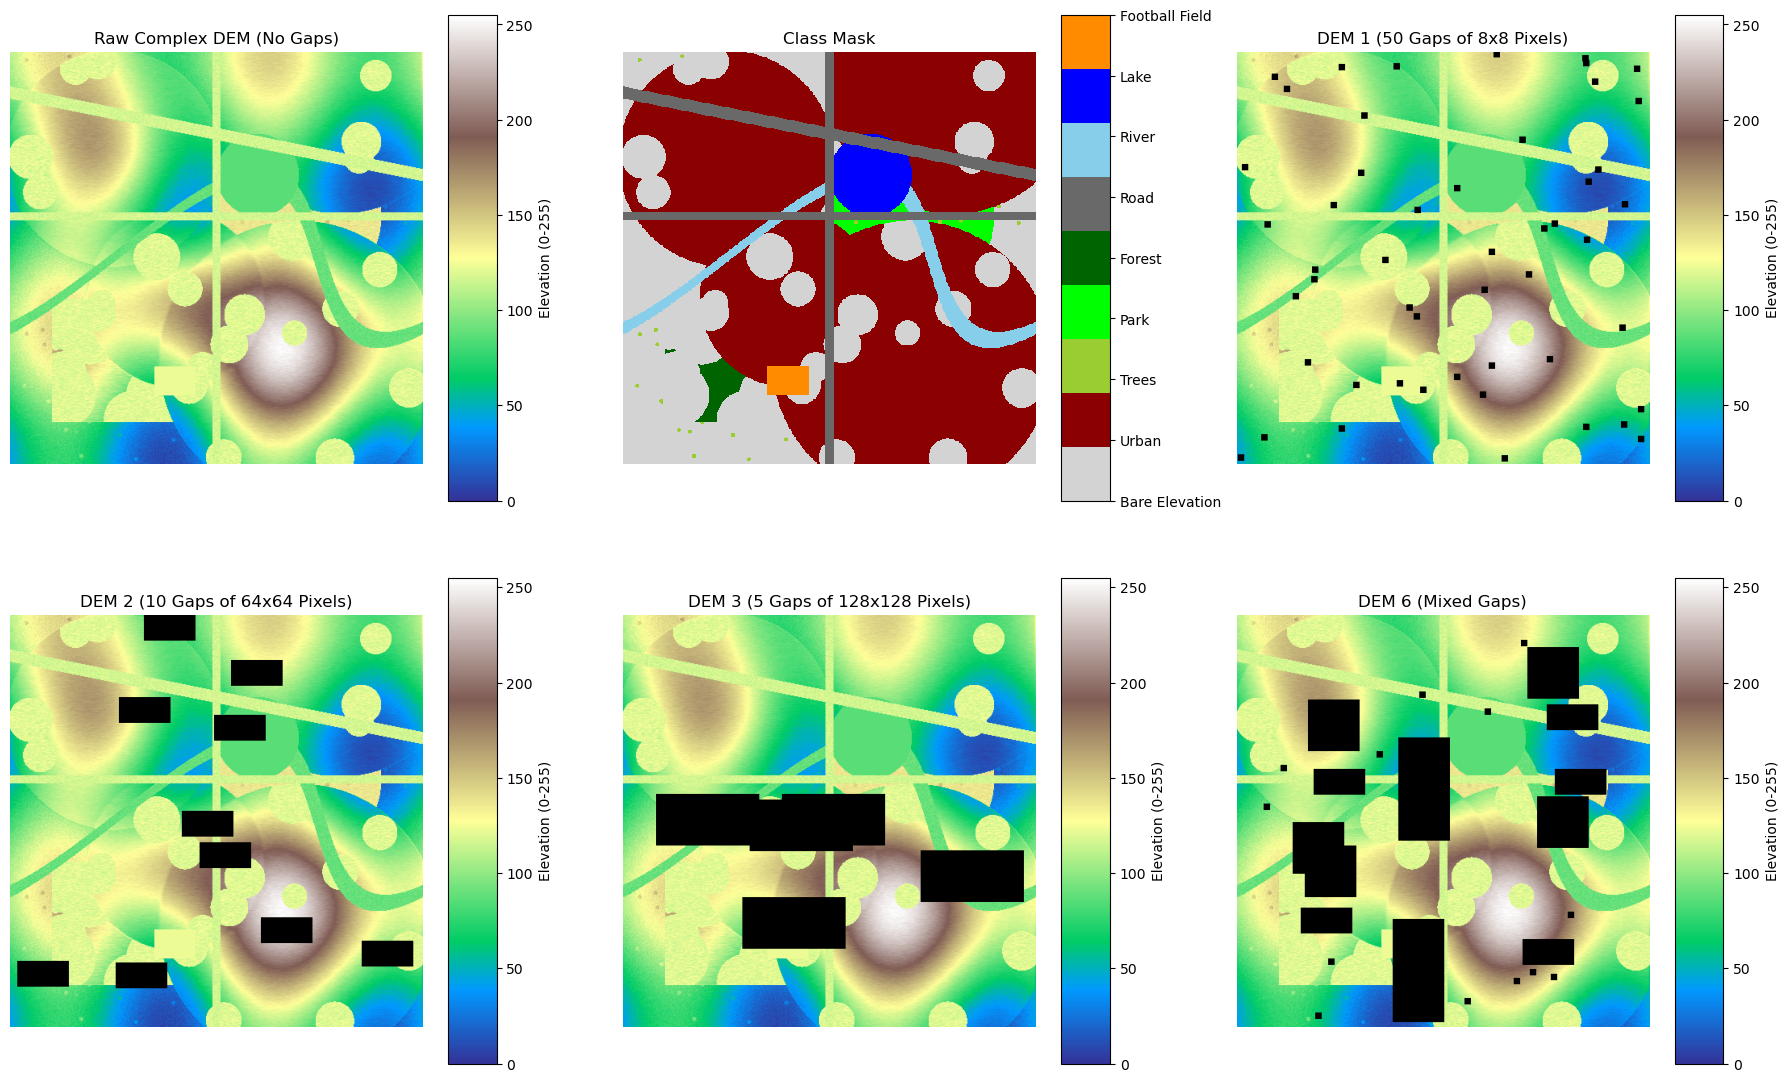

In [ ]:
ps = 512#256 #512 #1024
n_grid1_dem = 50
n_grid2_dem = 10
n_grid3_dem = 5
# Define the common grid shape
grid_shape = (ps, ps)
# Simulate the base complex DEM, unpacking all returned values for later use.
# global_X and global_Y contain the meshgrid coordinates.
# base_dem is the complete DEM data.
# class_mask is the segmentation mask.
global_X, global_Y, base_dem, class_mask = simulate_complex_dem(grid_shape)


# --- Generate the four different DEMs with gaps ---

# 1. DEM with 8x8 pixel gaps, 20 blocks
grid1_dem = create_grid_with_gaps(base_dem, (8, 8), n_grid1_dem)

# 2. DEM with 64x64 pixel gaps, 10 blocks
grid2_dem = create_grid_with_gaps(base_dem, (32, 64), n_grid2_dem)

# 3. DEM with 128x128 pixel gaps, 10 blocks
grid3_dem = create_grid_with_gaps(base_dem, (64, 128), n_grid3_dem)

# 4. DEM with a mix of block sizes and counts
mixed_grid_dem = base_dem.copy() # Start with a copy of the base DEM

grid_height, grid_width = grid_shape

# Apply 5 blocks of 8x8 pixels to the mixed grid.
num_8x8_mixed = n_grid1_dem //3
block_h_8, block_w_8 = (8, 8)
for _ in range(num_8x8_mixed):
    start_y = np.random.randint(0, grid_height - block_h_8 + 1)
    start_x = np.random.randint(0, grid_width - block_w_8 + 1)
    mixed_grid_dem[start_y:start_y+block_h_8, start_x:start_x+block_w_8] = np.nan


num_64x64_mixed = n_grid2_dem//2
block_h_64, block_w_64 = (32, 64)
for _ in range(num_64x64_mixed):
    start_y = np.random.randint(0, grid_height - block_h_64 + 1)
    start_x = np.random.randint(0, grid_width - block_w_64 + 1)
    mixed_grid_dem[start_y:start_y+block_h_64, start_x:start_x+block_w_64] = np.nan

# Apply 3 blocks of 64x64 pixels to the mixed grid.
num_64x64_mixed = n_grid2_dem//2
block_h_64, block_w_64 = (64, 64)
for _ in range(num_64x64_mixed):
    start_y = np.random.randint(0, grid_height - block_h_64 + 1)
    start_x = np.random.randint(0, grid_width - block_w_64 + 1)
    mixed_grid_dem[start_y:start_y+block_h_64, start_x:start_x+block_w_64] = np.nan

# Apply 2 blocks of 128x128 pixels to the mixed grid.
num_128x128_mixed = 2
block_h_128, block_w_128 = (128, 64)
for _ in range(num_128x128_mixed):
    start_y = np.random.randint(0, grid_height - block_h_128 + 1)
    start_x = np.random.randint(0, grid_width - block_w_128 + 1)
    mixed_grid_dem[start_y:start_y+block_h_128, start_x:start_x+block_w_128] = np.nan

# Create a masked array for the mixed grid with NaN values.
mixed_grid_dem = np.ma.masked_invalid(mixed_grid_dem)


# --- Plotting the DEMs and Class Mask as 2x3 subplots ---

fig, axes = plt.subplots(2, 3, figsize=(18, 12)) # 2 rows, 3 columns
axes = axes.flatten() # Flatten the 2D array of axes for easier iteration

# Titles for each subplot.
titles = [
    "Raw Complex DEM (No Gaps)",
    "Class Mask",
    f"DEM 1 ({n_grid1_dem} Gaps of 8x8 Pixels)",
    f"DEM 2 ({n_grid2_dem} Gaps of 64x64 Pixels)",
    f"DEM 3 ({n_grid3_dem} Gaps of 128x128 Pixels)",
    "DEM 6 (Mixed Gaps)"
]

# List of grids to plot, including the raw DEM and the class mask.
grids_to_plot = [base_dem, class_mask, grid1_dem, grid2_dem, grid3_dem, mixed_grid_dem]

# Get the 'terrain' colormap and set its 'bad' value color to black for gaps.
terrain_cmap = cm.get_cmap('terrain')
terrain_cmap.set_bad('black')

# Define a custom colormap for the classes for better visualization.
class_colors = [
    'lightgray',  # 0: Bare Elevation
    'darkred',    # 1: Urban
    'yellowgreen',# 2: Trees
    'lime',       # 3: Park
    'darkgreen',  # 4: Forest
    'dimgray',    # 5: Road
    'skyblue',    # 6: River
    'blue',       # 7: Lake
    'darkorange'  # 8: Football Field
]
# Create a ListedColormap to map integer class labels to specific colors.
# Ensure the colormap only uses colors for classes actually present
unique_classes_in_mask = np.unique(class_mask)
cmap_classes = ListedColormap([class_colors[c] for c in sorted(unique_classes_in_mask) if c != -1])

# Define a dictionary for class labels to display in the colorbar.
class_labels_map = {
    0: 'Bare Elevation', 1: 'Urban', 2: 'Trees', 3: 'Park', 4: 'Forest',
    5: 'Road', 6: 'River', 7: 'Lake', 8: 'Football Field'
}

# Iterate through axes and plot each grid.
for i, ax in enumerate(axes):
    if grids_to_plot[i] is class_mask:
        # Plot the class mask
        bounds = np.array(list(np.unique(class_mask)))
        bounds = bounds[bounds != -1] # Remove -1 if present
        if bounds.size > 0:
            norm_classes = Normalize(bounds.min(), bounds.max())
        else:
            norm_classes = Normalize(0, 1)

        im = ax.imshow(grids_to_plot[i], cmap=cmap_classes, norm=norm_classes, interpolation='nearest')
        ax.set_title(titles[i])
        ax.axis('off')

        # Add a colorbar for the class mask
        if bounds.size > 0:
            cbar = fig.colorbar(im, ax=ax, ticks=bounds, shrink=0.8, aspect=10)
            cbar.ax.set_yticklabels([class_labels_map.get(b, f'Class {b}') for b in bounds])
    else:
        # Plot DEMs (raw and gapped)
        im = ax.imshow(grids_to_plot[i], cmap=terrain_cmap, vmin=0, vmax=255)
        ax.set_title(titles[i])
        ax.axis('off')
        # Add a colorbar for DEMs (continuous)
        cbar = fig.colorbar(im, ax=ax, shrink=0.8, aspect=10)
        cbar.set_label('Elevation (0-255)')


plt.tight_layout() # Adjust layout to prevent overlaps.
plt.show() # Display the combined plot.

# use X,Y and Z from the dem with voids 
# use this to fill the nuls    
#  estimator=RandomForestRegressor(n_estimators=10, random_state=42),
#     random_state=42,
#     max_iter=5
# )
# df_rf_iterative = pd.DataFrame(
#     rf_iterative_imputer.fit_transform(df),
#     columns=df.columns,
#     index=df.index
# )
# plot the original dem, the void dem, the fill dem as 1x3 
# do this for every single dem with voids

Imputing DEM 1...
Imputing DEM 2...
Imputing DEM 3...
Imputing Mixed DEM...


/tmp/ipykernel_183370/3720842544.py:370: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  terrain_cmap = cm.get_cmap('terrain')


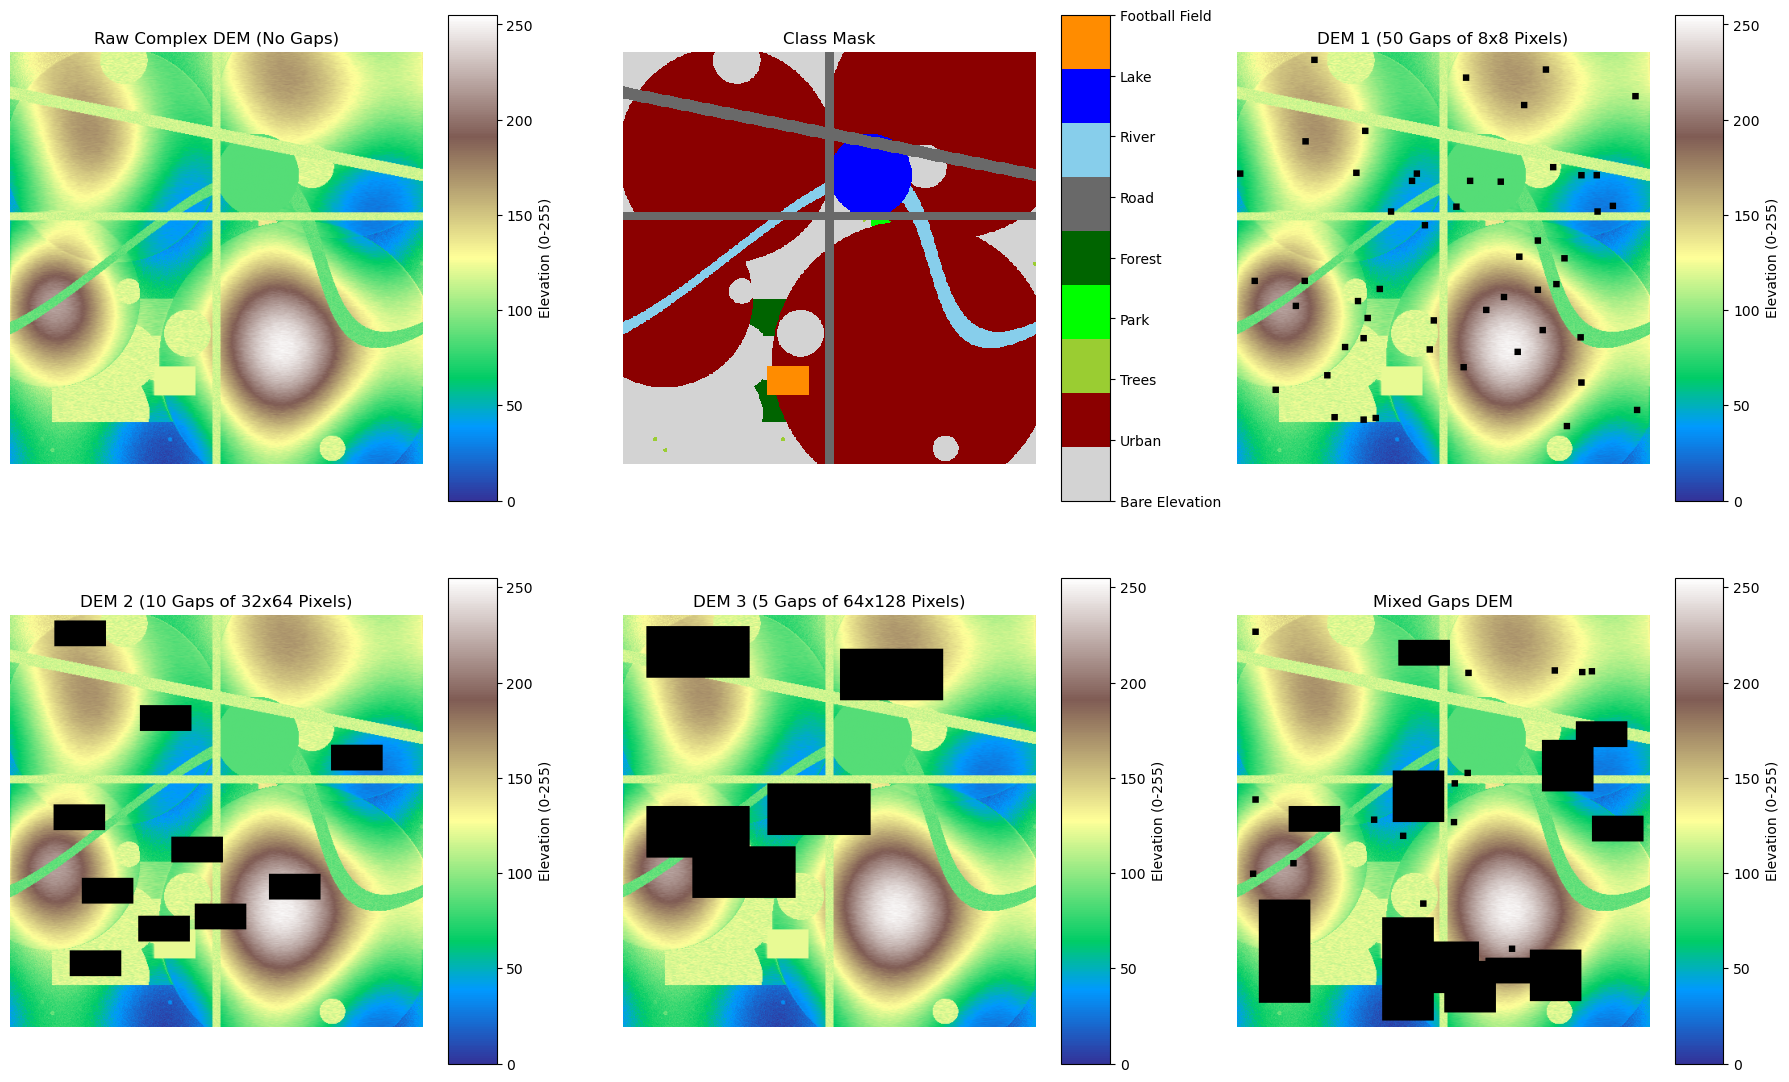

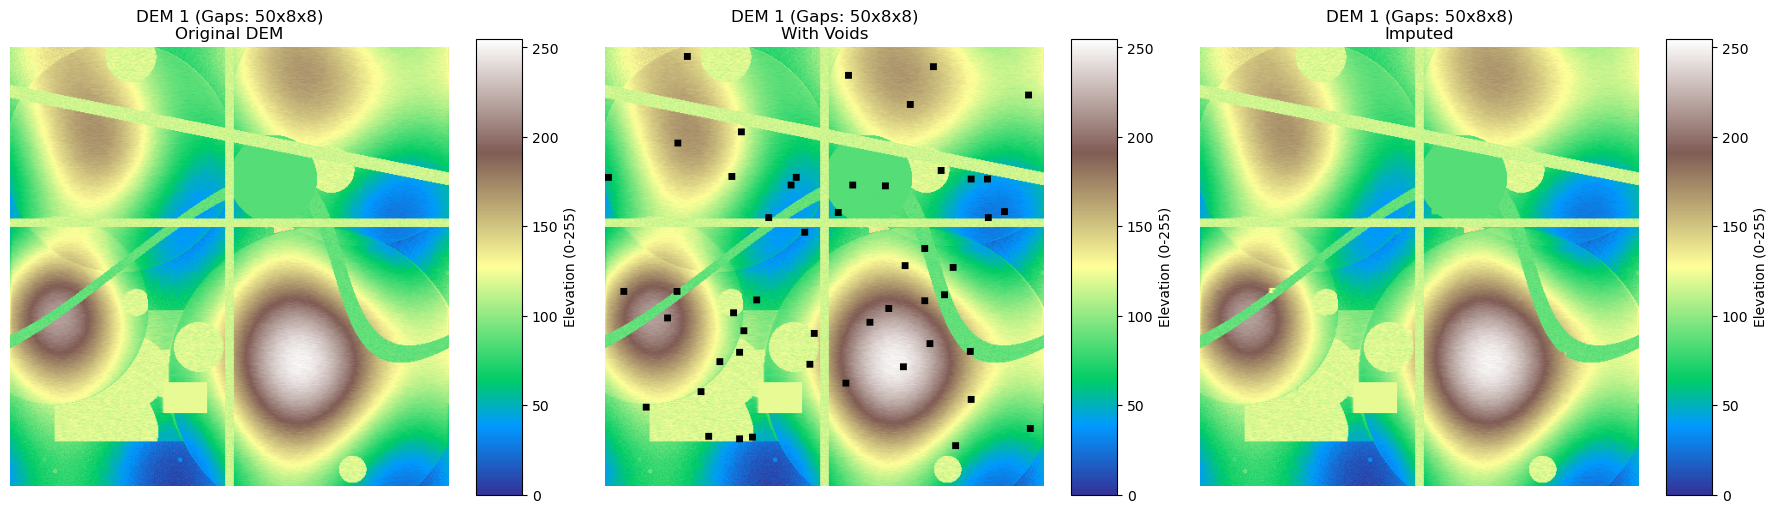

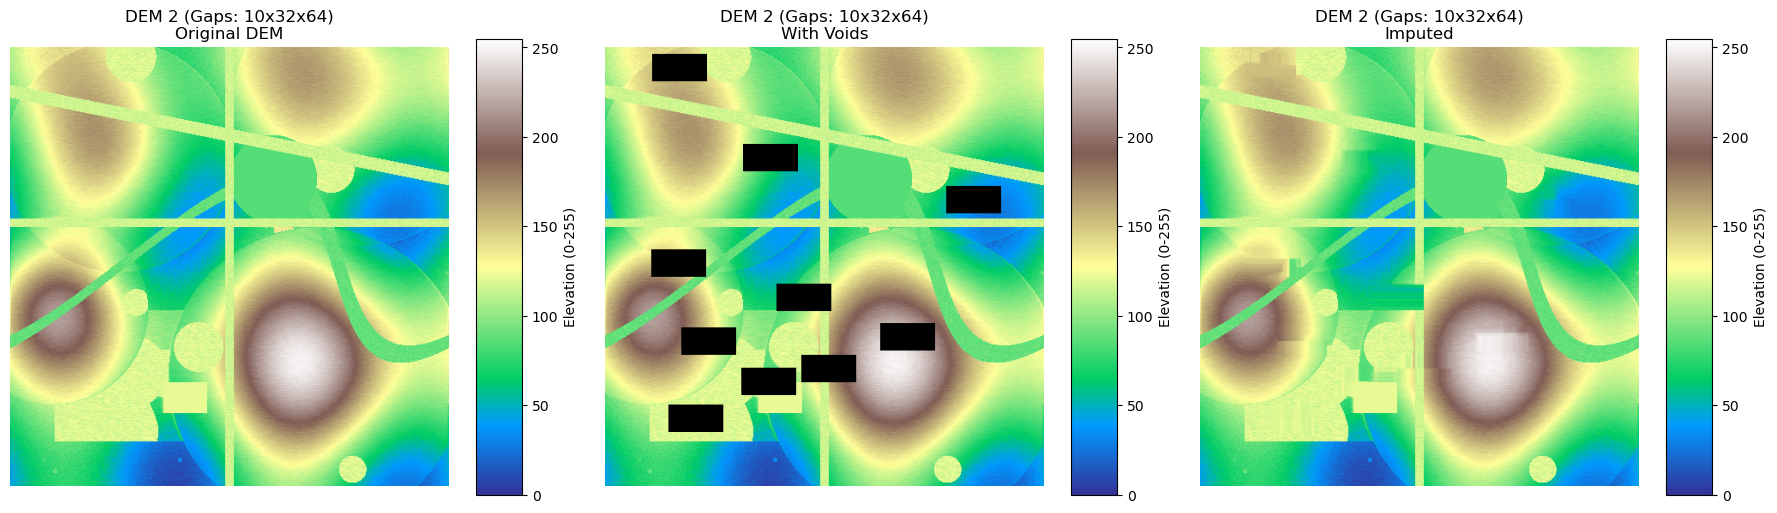

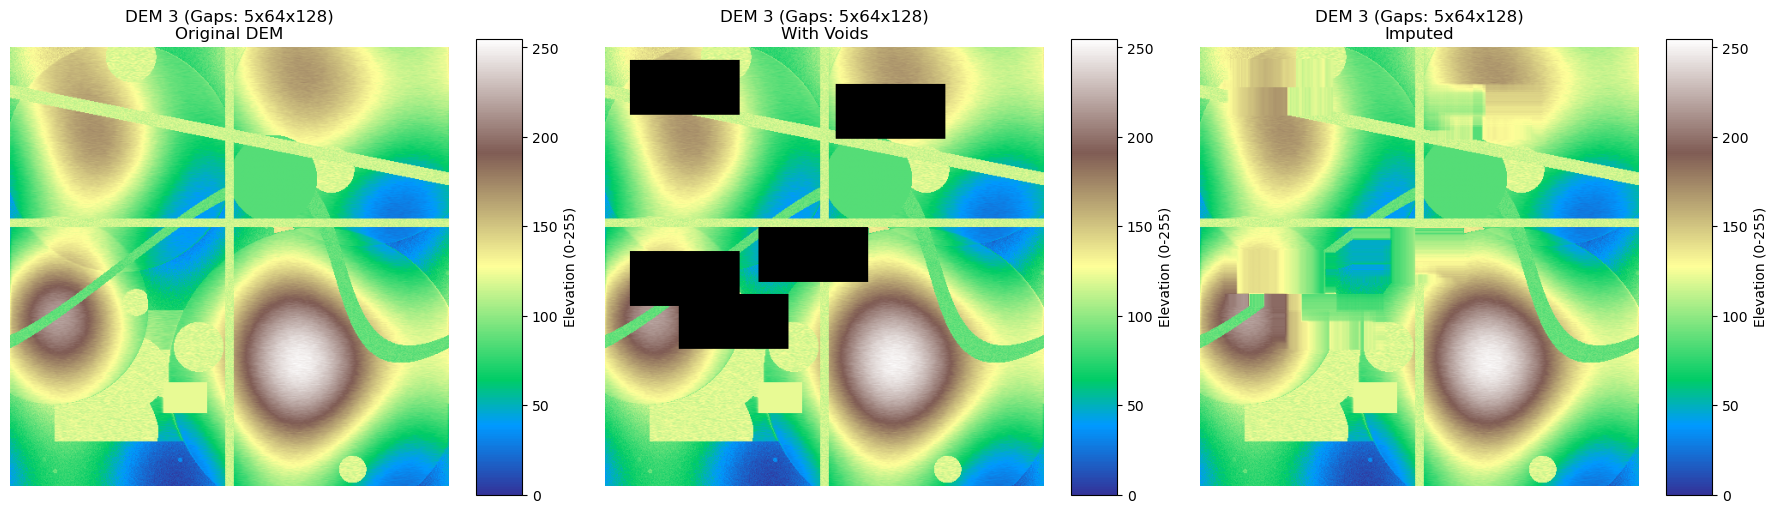

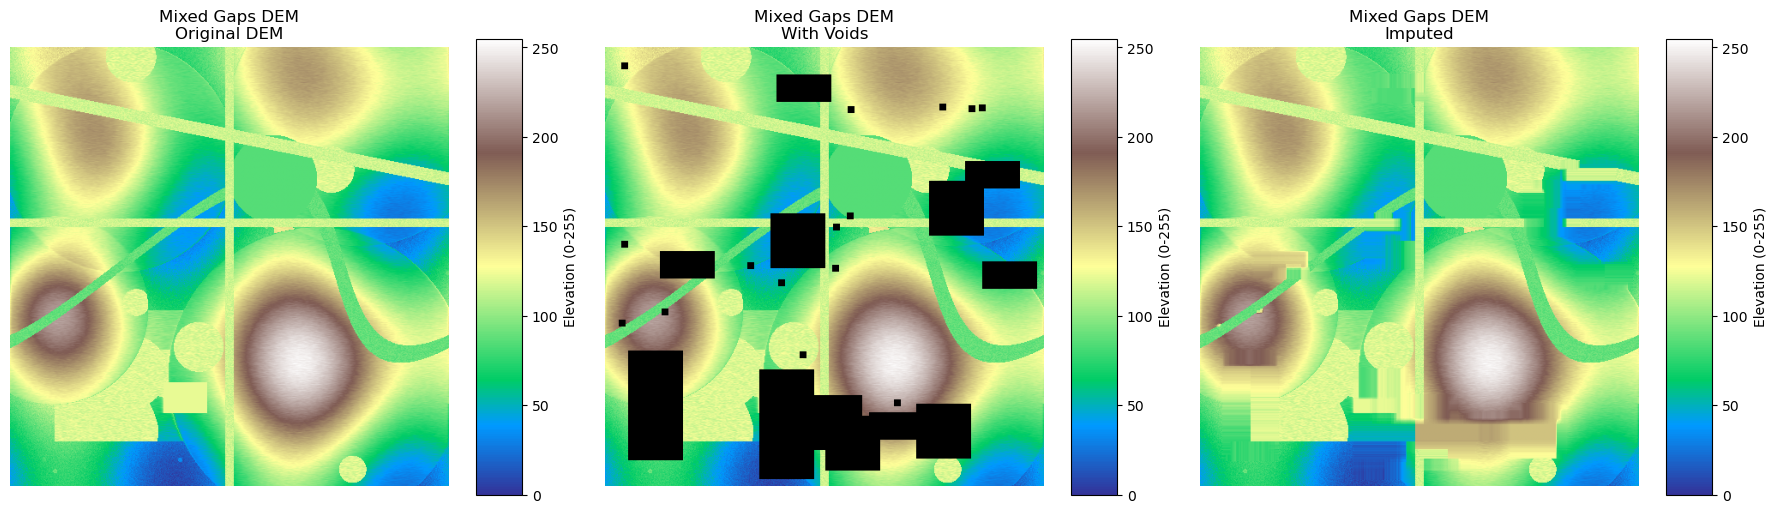

In [22]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm # Import cm for colormap handling
from scipy.ndimage import gaussian_filter # For smoothing features
from matplotlib.colors import ListedColormap, Normalize # For custom colormap for classes and normalization
import pandas as pd # For DataFrame manipulation, useful for imputation
from sklearn.experimental import enable_iterative_imputer # Required for IterativeImputer
from sklearn.impute import IterativeImputer
from sklearn.ensemble import RandomForestRegressor

def simulate_complex_dem(shape=(256, 256)):
    """
    Simulates a digital elevation model (DEM) for a complex environment
    including urban areas, trees, parks, forest, roads, river, lake,
    football field, bare elevations, and new bare earth clearings within
    urban and forest zones.

    Args:
        shape (tuple): The desired shape of the DEM grid (height, width).

    Returns:
        tuple: A tuple containing:
            - X (numpy.ndarray): The x-coordinates of the grid.
            - Y (numpy.ndarray): The y-coordinates of the grid.
            - Z_scaled (numpy.ndarray): A 2D array representing the urban DEM, values scaled 0-255.
            - class_mask (numpy.ndarray): A 2D array representing the class labels for each pixel.
    """
    height, width = shape
    x = np.linspace(0, 1, width)
    y = np.linspace(0, 1, height)
    X, Y = np.meshgrid(x, y)

    # Initialize Z (elevation) and class_mask
    Z = np.zeros(shape, dtype=np.float32)
    # Initialize with -1 for unassigned, will be overwritten by specific classes
    class_mask = np.full(shape, -1, dtype=np.int32)

    # Define class labels for the mask
    # Using 0 for bare elevation and subsequent integers for other features.
    CLASS_BARE_ELEVATION = 0
    CLASS_URBAN = 1
    CLASS_TREES = 2
    CLASS_PARK = 3
    CLASS_FOREST = 4
    CLASS_ROAD = 5
    CLASS_RIVER = 6
    CLASS_LAKE = 7
    CLASS_FOOTBALL_FIELD = 8

    # --- Bare Elevations (Base Terrain) ---
    # Gentle slopes using sine and cosine waves for the base elevation.
    Z = 50 * (np.sin(X * 4 * np.pi) + np.cos(Y * 3 * np.pi))
    # Assign bare elevation to all pixels initially, will be overwritten by other features
    class_mask[Z > -np.inf] = CLASS_BARE_ELEVATION
    # Add some general random noise for a more natural look on bare ground.
    Z += np.random.normal(0, 5, size=shape)

    # --- Urban Areas ---
    # Simulate multiple "building" like structures using Gaussian peaks.
    urban_areas_mask = np.zeros(shape, dtype=bool)
    building_coords = [(0.25, 0.25), (0.7, 0.75), (0.1, 0.6), (0.8, 0.15)]
    building_heights = [150, 180, 120, 100]
    building_scales = [0.03, 0.05, 0.02, 0.04] # Controls sharpness/spread of buildings

    for (bx, by), bh, bs in zip(building_coords, building_heights, building_scales):
        building_shape = np.exp(-((X - bx)**2 + (Y - by)**2) / bs)
        # Add height only where the building shape is significant
        Z[building_shape > 0.1] += building_shape[building_shape > 0.1] * bh
        urban_areas_mask[building_shape > 0.1] = True # Mark pixels as urban

    # Apply a slight Gaussian filter to urban areas for smoother transitions
    # This helps in creating plateaus or large blocks rather than sharp points.
    Z[urban_areas_mask] = gaussian_filter(Z[urban_areas_mask], sigma=1.5)
    class_mask[urban_areas_mask] = CLASS_URBAN

    # --- River ---
    # Create a winding river path.
    river_width = 0.02
    river_path_y = 0.5 + 0.2 * np.sin(X * 2 * np.pi + Y * np.pi) # Sine wave for winding path
    river_mask = np.abs(Y - river_path_y) < river_width
    # Set river elevation to a low, relatively flat value.
    Z[river_mask] = np.random.uniform(10, 30, size=Z[river_mask].shape)
    class_mask[river_mask] = CLASS_RIVER
    # Smooth river edges slightly for a natural look.
    Z[river_mask] = gaussian_filter(Z[river_mask], sigma=0.5)

    # --- Lake ---
    # Create a roughly circular lake.
    lake_center_x, lake_center_y = 0.6, 0.3
    lake_radius = 0.1
    lake_dist = np.sqrt((X - lake_center_x)**2 + (Y - lake_center_y)**2)
    lake_mask = lake_dist < lake_radius
    # Set lake elevation to be very low and flat.
    Z[lake_mask] = np.random.uniform(5, 25, size=Z[lake_mask].shape)
    class_mask[lake_mask] = CLASS_LAKE
    # Ensure lake is perfectly flat for realism.
    Z[lake_mask] = Z[lake_mask].mean()

    # --- Roads ---
    # Define a couple of intersecting roads and a diagonal one.
    road_width = 0.01
    road1_mask = np.abs(Y - 0.4) < road_width
    road2_mask = np.abs(X - 0.5) < road_width
    # Diagonal road example
    road3_mask = np.abs(Y - (0.1 + 0.2 * X)) < road_width * 1.5
    road_mask = road1_mask | road2_mask | road3_mask

    # Prioritize roads over existing features (e.g., bare elevation) where they overlap.
    # Roads are set to a mid-range flat elevation.
    Z[road_mask] = np.random.uniform(50, 70, size=Z[road_mask].shape)
    class_mask[road_mask] = CLASS_ROAD
    # Smooth roads to ensure they are flat.
    Z[road_mask] = gaussian_filter(Z[road_mask], sigma=0.5)

    # --- Football Field ---
    # Define a rectangular area for a football field.
    field_center_x, field_center_y = 0.4, 0.8
    field_width, field_height = 0.1, 0.07
    field_mask = (X > field_center_x - field_width/2) & (X < field_center_x + field_width/2) & \
                 (Y > field_center_y - field_height/2) & (Y < field_center_y + field_height/2)

    # Ensure football field is flat and at a typical "ground" level.
    Z[field_mask] = np.random.uniform(60, 80, size=Z[field_mask].shape)
    class_mask[field_mask] = CLASS_FOOTBALL_FIELD
    Z[field_mask] = Z[field_mask].mean() # Make it perfectly flat

    # --- Parks (flat green spaces) ---
    # Define a circular park area.
    park_center_x, park_center_y = 0.7, 0.4
    park_radius = 0.1
    park_dist = np.sqrt((X - park_center_x)**2 + (Y - park_center_y)**2)
    park_mask = park_dist < park_radius

    # Assign parks only where not already taken by more dominant features (roads, urban, water bodies).
    # Check if the existing class is bare elevation before assigning park.
    can_be_park = (class_mask == CLASS_BARE_ELEVATION)
    park_mask = park_mask & can_be_park
    Z[park_mask] = np.random.uniform(80, 100, size=Z[park_mask].shape) # Slightly elevated from base
    class_mask[park_mask] = CLASS_PARK
    Z[park_mask] = gaussian_filter(Z[park_mask], sigma=1.0) # Smooth park topography

    # --- Forest Areas (dense trees) ---
    # Define a large rectangular forest block.
    forest_mask = (X > 0.1) & (X < 0.4) & (Y > 0.6) & (Y < 0.9)

    # Only assign forest to areas that are currently bare elevation.
    can_be_forest = (class_mask == CLASS_BARE_ELEVATION)
    forest_mask = forest_mask & can_be_forest
    # Add height for trees in the forest.
    Z[forest_mask] += np.random.uniform(20, 50, size=Z[forest_mask].shape)
    class_mask[forest_mask] = CLASS_FOREST
    Z[forest_mask] = gaussian_filter(Z[forest_mask], sigma=2.0) # Smooth forest topography

    # --- Individual Trees (scattered) ---
    # Add small, distinct elevated bumps for individual trees.
    num_trees = 50
    for _ in range(num_trees):
        tx, ty = np.random.uniform(0, 1), np.random.uniform(0, 1)
        tree_radius = 0.005 # Small radius for individual trees
        tree_height = np.random.uniform(10, 30) # Small height for the bump
        tree_dist = np.sqrt((X - tx)**2 + (Y - ty)**2)
        tree_spot_mask = tree_dist < tree_radius
        # Only place trees where it's bare elevation or park, not on buildings, water, or roads.
        can_be_tree = (class_mask == CLASS_BARE_ELEVATION) | (class_mask == CLASS_PARK)
        tree_spot_mask = tree_spot_mask & can_be_tree
        Z[tree_spot_mask] += tree_height # Add a small elevation bump
        class_mask[tree_spot_mask] = CLASS_TREES

    # --- Add Batches of Bare Earth (Clearings/Undeveloped) within Urban and Forest Areas ---
    num_clearings_urban = 5 # Number of bare earth patches in urban areas
    clearing_size_urban_min = 0.03 # Min relative size of urban clearings
    clearing_size_urban_max = 0.06 # Max relative size of urban clearings

    num_clearings_forest = 8 # Number of bare earth patches in forest areas
    clearing_size_forest_min = 0.05 # Min relative size of forest clearings
    clearing_size_forest_max = 0.1 # Max relative size of forest clearings

    # Function to add clearings
    def add_clearings(target_mask, num_clearings, min_size, max_size):
        valid_indices = np.argwhere(target_mask)
        if valid_indices.size == 0:
            return

        for _ in range(num_clearings):
            # Choose a random center within the target area
            center_idx = valid_indices[np.random.randint(0, len(valid_indices))]
            center_y, center_x = center_idx[0], center_idx[1]

            # Convert pixel coordinates to normalized (0-1) coordinates
            norm_cx = center_x / width
            norm_cy = center_y / height

            # Randomize clearing size
            clearing_size = np.random.uniform(min_size, max_size)

            # Create a circular mask for the clearing
            clearing_dist = np.sqrt((X - norm_cx)**2 + (Y - norm_cy)**2)
            clearing_mask = clearing_dist < clearing_size

            # Ensure clearing is only placed within the target_mask and not on existing water/roads
            can_be_clearing = clearing_mask & target_mask & \
                              (class_mask != CLASS_RIVER) & (class_mask != CLASS_LAKE) & \
                              (class_mask != CLASS_ROAD) & (class_mask != CLASS_FOOTBALL_FIELD)

            # Apply bare earth elevation and class to the clearing area
            Z[can_be_clearing] = np.random.uniform(50, 80, size=Z[can_be_clearing].shape) # Mid-range bare earth elevation
            class_mask[can_be_clearing] = CLASS_BARE_ELEVATION
            Z[can_be_clearing] = gaussian_filter(Z[can_be_clearing], sigma=1.0) # Smooth clearing

    # Add bare earth clearings to urban areas
    add_clearings(urban_areas_mask, num_clearings_urban, clearing_size_urban_min, clearing_size_urban_max)

    # Add bare earth clearings to forest areas
    add_clearings(forest_mask, num_clearings_forest, clearing_size_forest_min, clearing_size_forest_max)

    # Final scaling of Z values to fit within 0-255 for visualization.
    Z_min, Z_max = Z.min(), Z.max()
    if Z_max - Z_min == 0:
        Z_scaled = np.zeros(shape, dtype=np.float32)
    else:
        Z_scaled = 255 * (Z - Z_min) / (Z_max - Z_min)

    # Return X, Y coordinates, the scaled DEM, and the class mask.
    return X, Y, Z_scaled.astype(np.float32), class_mask

def create_grid_with_gaps(base_grid, block_size=(8, 8), num_blocks=20):
    """
    Creates a copy of the base grid and inserts randomly placed 'gaps' (blocks of NaNs).
    These NaNs will be masked and plotted in black.

    Args:
        base_grid (numpy.ndarray): The initial DEM grid.
        block_size (tuple): The size of each gap block (block_height, block_width).
        num_blocks (int): The number of gap blocks to insert.

    Returns:
        numpy.ma.MaskedArray: The grid with the specified gaps, where gaps are masked.
    """
    grid_with_gaps = base_grid.copy()

    grid_height, grid_width = base_grid.shape
    block_height, block_width = block_size

    for _ in range(num_blocks):
        # Ensure the block fully fits within the grid boundaries.
        if grid_height - block_height < 0 or grid_width - block_width < 0:
            continue # Skip if block is larger than grid
        start_y = np.random.randint(0, grid_height - block_height + 1)
        start_x = np.random.randint(0, grid_width - block_width + 1)

        end_y = start_y + block_height
        end_x = start_x + block_width

        # Set the values within the selected block region to NaN, creating a "gap".
        grid_with_gaps[start_y:end_y, start_x:end_x] = np.nan

    # Create a masked array where NaN values are masked for plotting.
    return np.ma.masked_invalid(grid_with_gaps)

def impute_dem(X_coords, Y_coords, gapped_dem_ma, grid_shape):
    """
    Imputes NaN values in a gapped DEM using IterativeImputer with RandomForestRegressor.

    Args:
        X_coords (numpy.ndarray): X-coordinates meshgrid.
        Y_coords (numpy.ndarray): Y-coordinates meshgrid.
        gapped_dem_ma (numpy.ma.MaskedArray): The DEM with NaNs, as a masked array.
        grid_shape (tuple): The original shape of the grid (height, width).

    Returns:
        numpy.ndarray: The DEM with imputed values.
    """
    # Convert masked array to standard numpy array with NaNs
    gapped_dem_array = gapped_dem_ma.filled(np.nan)

    # Flatten the data for DataFrame creation
    X_flat = X_coords.flatten()
    Y_flat = Y_coords.flatten()
    Z_flat = gapped_dem_array.flatten()

    # Create a Pandas DataFrame for imputation
    df = pd.DataFrame({'X': X_flat, 'Y': Y_flat, 'Z': Z_flat})

    # Initialize the imputer
    # estimator=RandomForestRegressor(n_estimators=10, random_state=42)
    # random_state=42
    # max_iter=5
    rf_iterative_imputer = IterativeImputer(
        estimator=RandomForestRegressor(n_estimators=10, random_state=42),
        random_state=42,
        max_iter=5
    )

    # Perform imputation
    df_imputed = pd.DataFrame(
        rf_iterative_imputer.fit_transform(df),
        columns=df.columns,
        index=df.index
    )

    # Reshape the imputed 'Z' column back to the original grid shape
    imputed_dem = df_imputed['Z'].values.reshape(grid_shape)
    return imputed_dem

# --- Main Script Execution ---
ps = 512 # Set grid size to 512x512
n_grid1_dem = 50 # Number of gaps for DEM 1
n_grid2_dem = 10 # Number of gaps for DEM 2
n_grid3_dem = 5 # Number of gaps for DEM 3

# Define the common grid shape
grid_shape = (ps, ps)

# Simulate the base complex DEM, unpacking all returned values
global_X, global_Y, base_dem, class_mask = simulate_complex_dem(grid_shape)

# --- Generate the four different DEMs with gaps ---
grid1_dem_gapped = create_grid_with_gaps(base_dem, (8, 8), n_grid1_dem)
grid2_dem_gapped = create_grid_with_gaps(base_dem, (32, 64), n_grid2_dem)
grid3_dem_gapped = create_grid_with_gaps(base_dem, (64, 128), n_grid3_dem)

# DEM with a mix of block sizes and counts
mixed_grid_dem_gapped = base_dem.copy() # Start with a copy of the base DEM

grid_height, grid_width = grid_shape

# Apply different sized blocks to the mixed grid
num_8x8_mixed = n_grid1_dem // 3
block_h_8, block_w_8 = (8, 8)
for _ in range(num_8x8_mixed):
    start_y = np.random.randint(0, grid_height - block_h_8 + 1)
    start_x = np.random.randint(0, grid_width - block_w_8 + 1)
    mixed_grid_dem_gapped[start_y:start_y+block_h_8, start_x:start_x+block_w_8] = np.nan

num_32x64_mixed = n_grid2_dem // 2
block_h_32, block_w_32 = (32, 64)
for _ in range(num_32x64_mixed):
    start_y = np.random.randint(0, grid_height - block_h_32 + 1)
    start_x = np.random.randint(0, grid_width - block_w_32 + 1)
    mixed_grid_dem_gapped[start_y:start_y+block_h_32, start_x:start_x+block_w_32] = np.nan

num_64x64_mixed = n_grid2_dem // 2
block_h_64, block_w_64 = (64, 64)
for _ in range(num_64x64_mixed):
    start_y = np.random.randint(0, grid_height - block_h_64 + 1)
    start_x = np.random.randint(0, grid_width - block_w_64 + 1)
    mixed_grid_dem_gapped[start_y:start_y+block_h_64, start_x:start_x+block_w_64] = np.nan

num_128x64_mixed = n_grid3_dem // 2 # Adjusted to use n_grid3_dem
block_h_128, block_w_128 = (128, 64)
for _ in range(num_128x128_mixed):
    start_y = np.random.randint(0, grid_height - block_h_128 + 1)
    start_x = np.random.randint(0, grid_width - block_w_128 + 1)
    mixed_grid_dem_gapped[start_y:start_y+block_h_128, start_x:start_x+block_w_128] = np.nan

mixed_grid_dem_gapped = np.ma.masked_invalid(mixed_grid_dem_gapped)

# --- Impute the Gapped DEMs ---
print("Imputing DEM 1...")
grid1_dem_imputed = impute_dem(global_X, global_Y, grid1_dem_gapped, grid_shape)
print("Imputing DEM 2...")
grid2_dem_imputed = impute_dem(global_X, global_Y, grid2_dem_gapped, grid_shape)
print("Imputing DEM 3...")
grid3_dem_imputed = impute_dem(global_X, global_Y, grid3_dem_gapped, grid_shape)
print("Imputing Mixed DEM...")
mixed_grid_dem_imputed = impute_dem(global_X, global_Y, mixed_grid_dem_gapped, grid_shape)

# --- Define plotting assets (colormaps, titles, etc.) ---
# Get the 'terrain' colormap and set its 'bad' value color to black for gaps.
terrain_cmap = cm.get_cmap('terrain')
terrain_cmap.set_bad('black')

# Define a custom colormap for the classes for better visualization.
class_colors = [
    'lightgray',  # 0: Bare Elevation
    'darkred',    # 1: Urban
    'yellowgreen',# 2: Trees
    'lime',       # 3: Park
    'darkgreen',  # 4: Forest
    'dimgray',    # 5: Road
    'skyblue',    # 6: River
    'blue',       # 7: Lake
    'darkorange'  # 8: Football Field
]
unique_classes_in_mask = np.unique(class_mask)
cmap_classes = ListedColormap([class_colors[c] for c in sorted(unique_classes_in_mask) if c != -1])

class_labels_map = {
    0: 'Bare Elevation', 1: 'Urban', 2: 'Trees', 3: 'Park', 4: 'Forest',
    5: 'Road', 6: 'River', 7: 'Lake', 8: 'Football Field'
}

# --- Plotting the Raw DEM and Class Mask (2x3 main figure) ---
fig_main, axes_main = plt.subplots(2, 3, figsize=(18, 12))
axes_main = axes_main.flatten()

main_plot_titles = [
    "Raw Complex DEM (No Gaps)",
    "Class Mask",
    f"DEM 1 ({n_grid1_dem} Gaps of 8x8 Pixels)",
    f"DEM 2 ({n_grid2_dem} Gaps of 32x64 Pixels)", # Updated title to reflect block size
    f"DEM 3 ({n_grid3_dem} Gaps of 64x128 Pixels)", # Updated title to reflect block size
    "Mixed Gaps DEM"
]

main_grids_to_plot = [base_dem, class_mask, grid1_dem_gapped, grid2_dem_gapped, grid3_dem_gapped, mixed_grid_dem_gapped]

for i, ax in enumerate(axes_main):
    if main_grids_to_plot[i] is class_mask:
        bounds = np.array(list(np.unique(class_mask)))
        bounds = bounds[bounds != -1]
        norm_classes = Normalize(bounds.min(), bounds.max()) if bounds.size > 0 else Normalize(0, 1)

        im = ax.imshow(main_grids_to_plot[i], cmap=cmap_classes, norm=norm_classes, interpolation='nearest')
        ax.set_title(main_plot_titles[i])
        ax.axis('off')
        if bounds.size > 0:
            cbar = fig_main.colorbar(im, ax=ax, ticks=bounds, shrink=0.8, aspect=10)
            cbar.ax.set_yticklabels([class_labels_map.get(b, f'Class {b}') for b in bounds])
    else:
        im = ax.imshow(main_grids_to_plot[i], cmap=terrain_cmap, vmin=0, vmax=255)
        ax.set_title(main_plot_titles[i])
        ax.axis('off')
        cbar = fig_main.colorbar(im, ax=ax, shrink=0.8, aspect=10)
        cbar.set_label('Elevation (0-255)')

plt.tight_layout()
plt.show()

# --- Plotting Original, Gapped, and Imputed for each DEM ---

dem_sets_for_imputation_plot = [
    (grid1_dem_gapped, grid1_dem_imputed, f"DEM 1 (Gaps: {n_grid1_dem}x8x8)"),
    (grid2_dem_gapped, grid2_dem_imputed, f"DEM 2 (Gaps: {n_grid2_dem}x32x64)"),
    (grid3_dem_gapped, grid3_dem_imputed, f"DEM 3 (Gaps: {n_grid3_dem}x64x128)"),
    (mixed_grid_dem_gapped, mixed_grid_dem_imputed, "Mixed Gaps DEM")
]

for gapped_dem, imputed_dem, dem_title_prefix in dem_sets_for_imputation_plot:
    fig_impute, axes_impute = plt.subplots(1, 3, figsize=(18, 6))
    axes_impute = axes_impute.flatten()

    # Plot Raw DEM
    im0 = axes_impute[0].imshow(base_dem, cmap=terrain_cmap, vmin=0, vmax=255)
    axes_impute[0].set_title(f"{dem_title_prefix}\nOriginal DEM")
    axes_impute[0].axis('off')
    fig_impute.colorbar(im0, ax=axes_impute[0], shrink=0.8, aspect=10).set_label('Elevation (0-255)')

    # Plot Gapped DEM
    im1 = axes_impute[1].imshow(gapped_dem, cmap=terrain_cmap, vmin=0, vmax=255)
    axes_impute[1].set_title(f"{dem_title_prefix}\nWith Voids")
    axes_impute[1].axis('off')
    fig_impute.colorbar(im1, ax=axes_impute[1], shrink=0.8, aspect=10).set_label('Elevation (0-255)')

    # Plot Imputed DEM
    im2 = axes_impute[2].imshow(imputed_dem, cmap=terrain_cmap, vmin=0, vmax=255)
    axes_impute[2].set_title(f"{dem_title_prefix}\nImputed")
    axes_impute[2].axis('off')
    fig_impute.colorbar(im2, ax=axes_impute[2], shrink=0.8, aspect=10).set_label('Elevation (0-255)')

    plt.tight_layout()
    plt.show()


Imputing DEM 1...
Imputing DEM 2...
Imputing DEM 3...
Imputing Mixed DEM...


/tmp/ipykernel_183370/3480036923.py:387: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  terrain_cmap = cm.get_cmap('terrain')


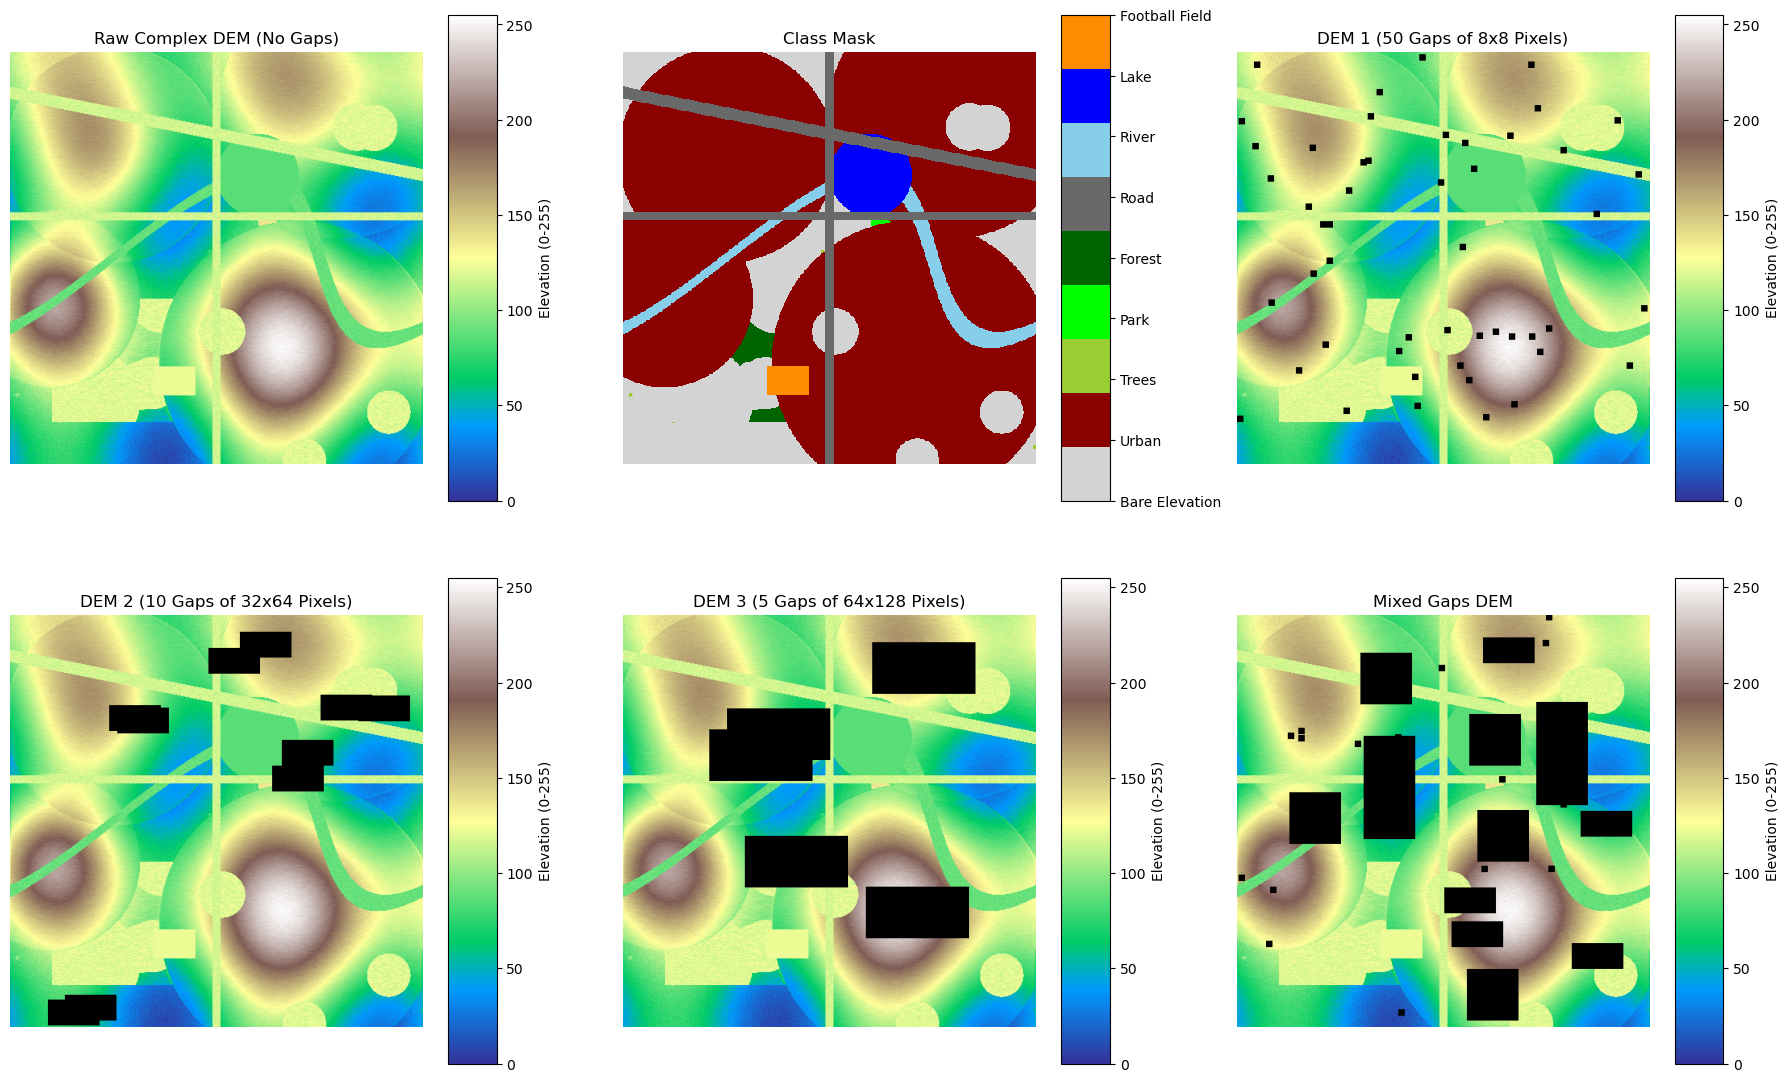

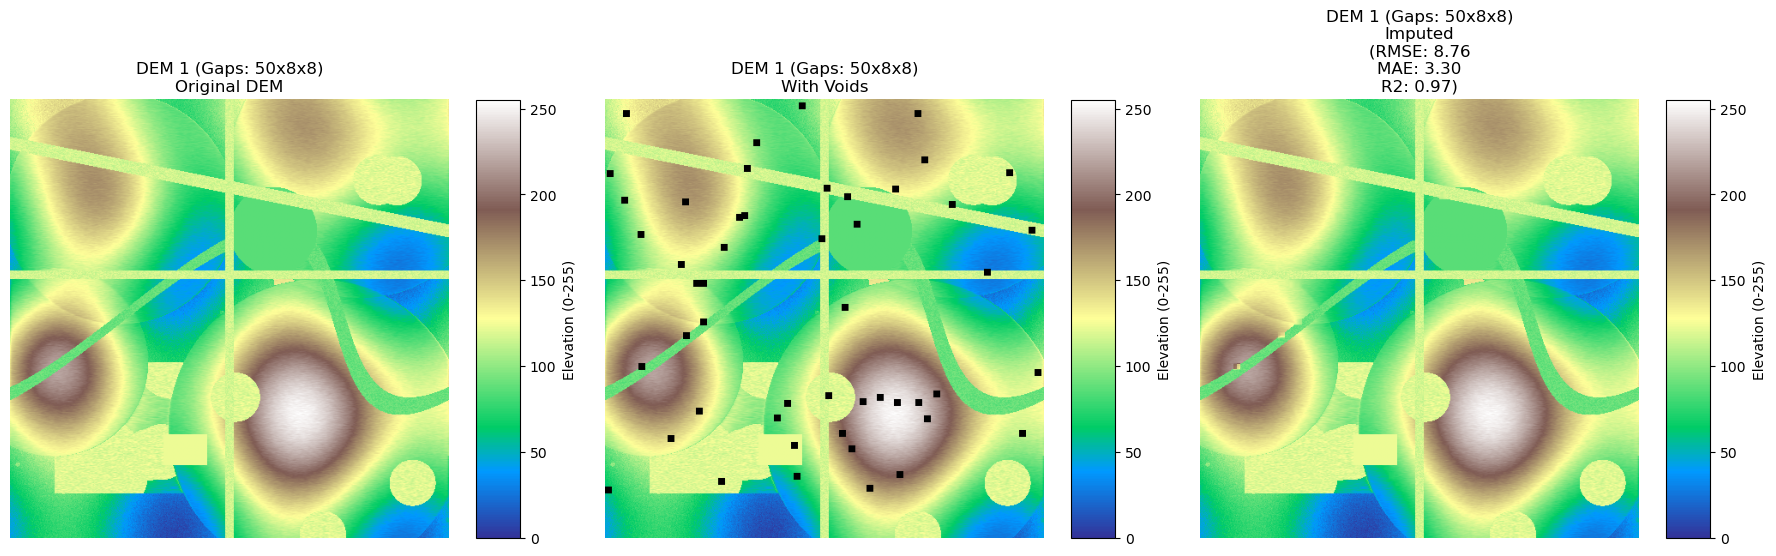

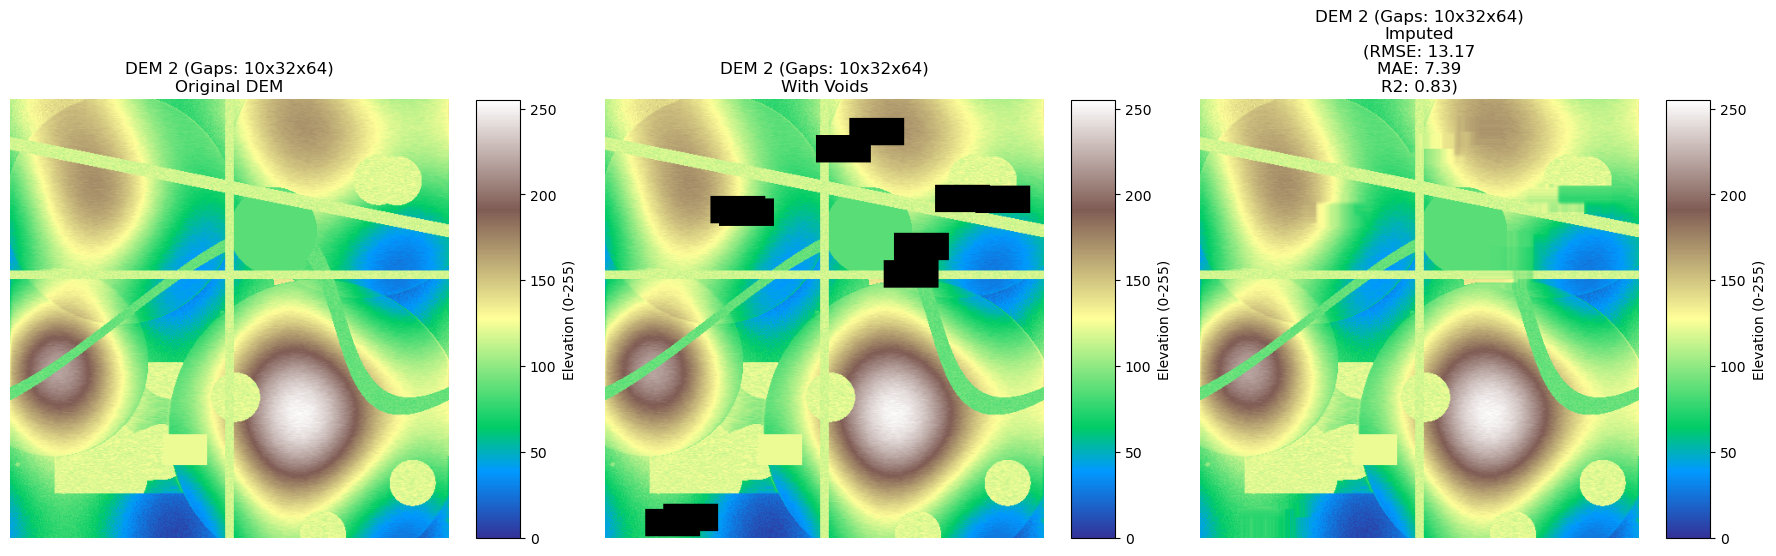

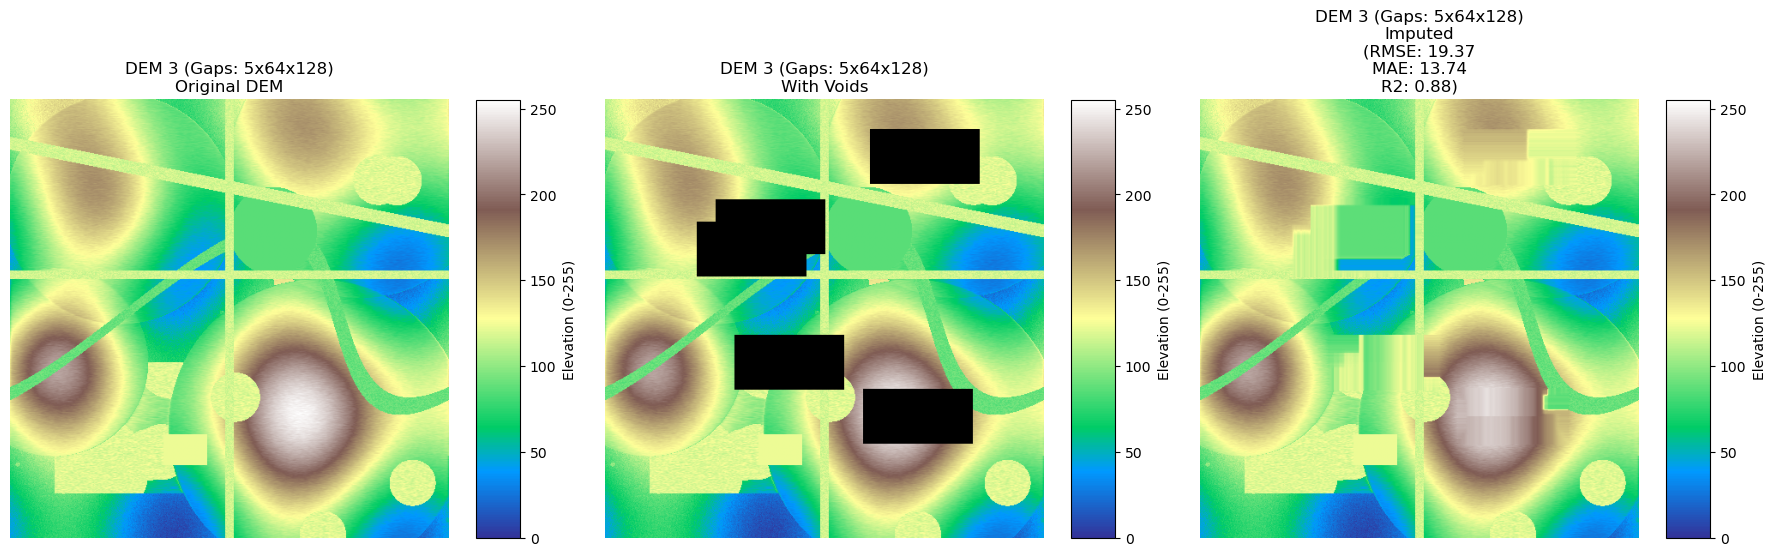

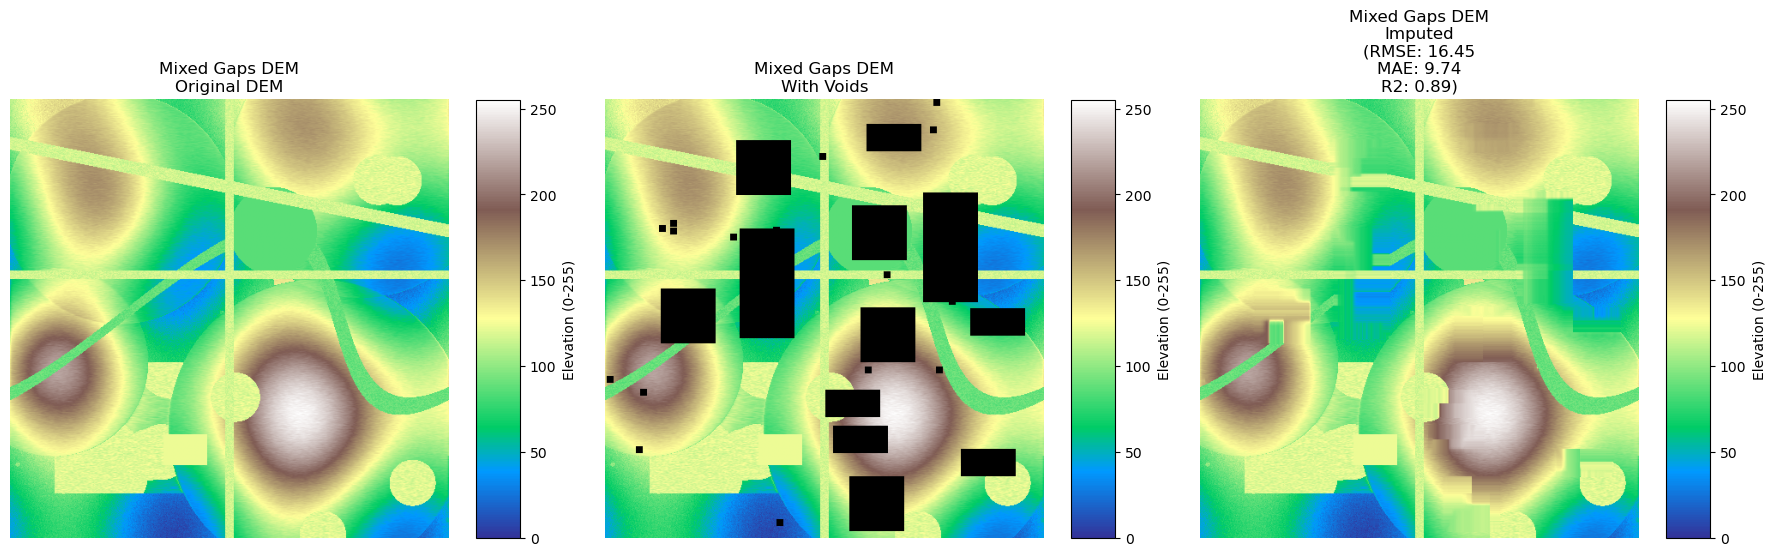

In [24]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm # Import cm for colormap handling
from scipy.ndimage import gaussian_filter # For smoothing features
from matplotlib.colors import ListedColormap, Normalize # For custom colormap for classes and normalization
import pandas as pd # For DataFrame manipulation, useful for imputation
from sklearn.experimental import enable_iterative_imputer # Required for IterativeImputer
from sklearn.impute import IterativeImputer
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score # Import metrics

def simulate_complex_dem(shape=(256, 256)):
    """
    Simulates a digital elevation model (DEM) for a complex environment
    including urban areas, trees, parks, forest, roads, river, lake,
    football field, bare elevations, and new bare earth clearings within
    urban and forest zones.

    Args:
        shape (tuple): The desired shape of the DEM grid (height, width).

    Returns:
        tuple: A tuple containing:
            - X (numpy.ndarray): The x-coordinates of the grid.
            - Y (numpy.ndarray): The y-coordinates of the grid.
            - Z_scaled (numpy.ndarray): A 2D array representing the urban DEM, values scaled 0-255.
            - class_mask (numpy.ndarray): A 2D array representing the class labels for each pixel.
    """
    height, width = shape
    x = np.linspace(0, 1, width)
    y = np.linspace(0, 1, height)
    X, Y = np.meshgrid(x, y)

    # Initialize Z (elevation) and class_mask
    Z = np.zeros(shape, dtype=np.float32)
    # Initialize with -1 for unassigned, will be overwritten by specific classes
    class_mask = np.full(shape, -1, dtype=np.int32)

    # Define class labels for the mask
    # Using 0 for bare elevation and subsequent integers for other features.
    CLASS_BARE_ELEVATION = 0
    CLASS_URBAN = 1
    CLASS_TREES = 2
    CLASS_PARK = 3
    CLASS_FOREST = 4
    CLASS_ROAD = 5
    CLASS_RIVER = 6
    CLASS_LAKE = 7
    CLASS_FOOTBALL_FIELD = 8

    # --- Bare Elevations (Base Terrain) ---
    # Gentle slopes using sine and cosine waves for the base elevation.
    Z = 50 * (np.sin(X * 4 * np.pi) + np.cos(Y * 3 * np.pi))
    # Assign bare elevation to all pixels initially, will be overwritten by other features
    class_mask[Z > -np.inf] = CLASS_BARE_ELEVATION
    # Add some general random noise for a more natural look on bare ground.
    Z += np.random.normal(0, 5, size=shape)

    # --- Urban Areas ---
    # Simulate multiple "building" like structures using Gaussian peaks.
    urban_areas_mask = np.zeros(shape, dtype=bool)
    building_coords = [(0.25, 0.25), (0.7, 0.75), (0.1, 0.6), (0.8, 0.15)]
    building_heights = [150, 180, 120, 100]
    building_scales = [0.03, 0.05, 0.02, 0.04] # Controls sharpness/spread of buildings

    for (bx, by), bh, bs in zip(building_coords, building_heights, building_scales):
        building_shape = np.exp(-((X - bx)**2 + (Y - by)**2) / bs)
        # Add height only where the building shape is significant
        Z[building_shape > 0.1] += building_shape[building_shape > 0.1] * bh
        urban_areas_mask[building_shape > 0.1] = True # Mark pixels as urban

    # Apply a slight Gaussian filter to urban areas for smoother transitions
    # This helps in creating plateaus or large blocks rather than sharp points.
    Z[urban_areas_mask] = gaussian_filter(Z[urban_areas_mask], sigma=1.5)
    class_mask[urban_areas_mask] = CLASS_URBAN

    # --- River ---
    # Create a winding river path.
    river_width = 0.02
    river_path_y = 0.5 + 0.2 * np.sin(X * 2 * np.pi + Y * np.pi) # Sine wave for winding path
    river_mask = np.abs(Y - river_path_y) < river_width
    # Set river elevation to a low, relatively flat value.
    Z[river_mask] = np.random.uniform(10, 30, size=Z[river_mask].shape)
    class_mask[river_mask] = CLASS_RIVER
    # Smooth river edges slightly for a natural look.
    Z[river_mask] = gaussian_filter(Z[river_mask], sigma=0.5)

    # --- Lake ---
    # Create a roughly circular lake.
    lake_center_x, lake_center_y = 0.6, 0.3
    lake_radius = 0.1
    lake_dist = np.sqrt((X - lake_center_x)**2 + (Y - lake_center_y)**2)
    lake_mask = lake_dist < lake_radius
    # Set lake elevation to be very low and flat.
    Z[lake_mask] = np.random.uniform(5, 25, size=Z[lake_mask].shape)
    class_mask[lake_mask] = CLASS_LAKE
    # Ensure lake is perfectly flat for realism.
    Z[lake_mask] = Z[lake_mask].mean()

    # --- Roads ---
    # Define a couple of intersecting roads and a diagonal one.
    road_width = 0.01
    road1_mask = np.abs(Y - 0.4) < road_width
    road2_mask = np.abs(X - 0.5) < road_width
    # Diagonal road example
    road3_mask = np.abs(Y - (0.1 + 0.2 * X)) < road_width * 1.5
    road_mask = road1_mask | road2_mask | road3_mask

    # Prioritize roads over existing features (e.g., bare elevation) where they overlap.
    # Roads are set to a mid-range flat elevation.
    Z[road_mask] = np.random.uniform(50, 70, size=Z[road_mask].shape)
    class_mask[road_mask] = CLASS_ROAD
    # Smooth roads to ensure they are flat.
    Z[road_mask] = gaussian_filter(Z[road_mask], sigma=0.5)

    # --- Football Field ---
    # Define a rectangular area for a football field.
    field_center_x, field_center_y = 0.4, 0.8
    field_width, field_height = 0.1, 0.07
    field_mask = (X > field_center_x - field_width/2) & (X < field_center_x + field_width/2) & \
                 (Y > field_center_y - field_height/2) & (Y < field_center_y + field_height/2)

    # Ensure football field is flat and at a typical "ground" level.
    Z[field_mask] = np.random.uniform(60, 80, size=Z[field_mask].shape)
    class_mask[field_mask] = CLASS_FOOTBALL_FIELD
    Z[field_mask] = Z[field_mask].mean() # Make it perfectly flat

    # --- Parks (flat green spaces) ---
    # Define a circular park area.
    park_center_x, park_center_y = 0.7, 0.4
    park_radius = 0.1
    park_dist = np.sqrt((X - park_center_x)**2 + (Y - park_center_y)**2)
    park_mask = park_dist < park_radius

    # Assign parks only where not already taken by more dominant features (roads, urban, water bodies).
    # Check if the existing class is bare elevation before assigning park.
    can_be_park = (class_mask == CLASS_BARE_ELEVATION)
    park_mask = park_mask & can_be_park
    Z[park_mask] = np.random.uniform(80, 100, size=Z[park_mask].shape) # Slightly elevated from base
    class_mask[park_mask] = CLASS_PARK
    Z[park_mask] = gaussian_filter(Z[park_mask], sigma=1.0) # Smooth park topography

    # --- Forest Areas (dense trees) ---
    # Define a large rectangular forest block.
    forest_mask = (X > 0.1) & (X < 0.4) & (Y > 0.6) & (Y < 0.9)

    # Only assign forest to areas that are currently bare elevation.
    can_be_forest = (class_mask == CLASS_BARE_ELEVATION)
    forest_mask = forest_mask & can_be_forest
    # Add height for trees in the forest.
    Z[forest_mask] += np.random.uniform(20, 50, size=Z[forest_mask].shape)
    class_mask[forest_mask] = CLASS_FOREST
    Z[forest_mask] = gaussian_filter(Z[forest_mask], sigma=2.0) # Smooth forest topography

    # --- Individual Trees (scattered) ---
    # Add small, distinct elevated bumps for individual trees.
    num_trees = 50
    for _ in range(num_trees):
        tx, ty = np.random.uniform(0, 1), np.random.uniform(0, 1)
        tree_radius = 0.005 # Small radius for individual trees
        tree_height = np.random.uniform(10, 30) # Small height for the bump
        tree_dist = np.sqrt((X - tx)**2 + (Y - ty)**2)
        tree_spot_mask = tree_dist < tree_radius
        # Only place trees where it's bare elevation or park, not on buildings, water, or roads.
        can_be_tree = (class_mask == CLASS_BARE_ELEVATION) | (class_mask == CLASS_PARK)
        tree_spot_mask = tree_spot_mask & can_be_tree
        Z[tree_spot_mask] += tree_height # Add a small elevation bump
        class_mask[tree_spot_mask] = CLASS_TREES

    # --- Add Batches of Bare Earth (Clearings/Undeveloped) within Urban and Forest Areas ---
    num_clearings_urban = 5 # Number of bare earth patches in urban areas
    clearing_size_urban_min = 0.03 # Min relative size of urban clearings
    clearing_size_urban_max = 0.06 # Max relative size of urban clearings

    num_clearings_forest = 8 # Number of bare earth patches in forest areas
    clearing_size_forest_min = 0.05 # Min relative size of forest clearings
    clearing_size_forest_max = 0.1 # Max relative size of forest clearings

    # Function to add clearings
    def add_clearings(target_mask, num_clearings, min_size, max_size):
        valid_indices = np.argwhere(target_mask)
        if valid_indices.size == 0:
            return

        for _ in range(num_clearings):
            # Choose a random center within the target area
            center_idx = valid_indices[np.random.randint(0, len(valid_indices))]
            center_y, center_x = center_idx[0], center_idx[1]

            # Convert pixel coordinates to normalized (0-1) coordinates
            norm_cx = center_x / width
            norm_cy = center_y / height

            # Randomize clearing size
            clearing_size = np.random.uniform(min_size, max_size)

            # Create a circular mask for the clearing
            clearing_dist = np.sqrt((X - norm_cx)**2 + (Y - norm_cy)**2)
            clearing_mask = clearing_dist < clearing_size

            # Ensure clearing is only placed within the target_mask and not on existing water/roads
            can_be_clearing = clearing_mask & target_mask & \
                              (class_mask != CLASS_RIVER) & (class_mask != CLASS_LAKE) & \
                              (class_mask != CLASS_ROAD) & (class_mask != CLASS_FOOTBALL_FIELD)

            # Apply bare earth elevation and class to the clearing area
            Z[can_be_clearing] = np.random.uniform(50, 80, size=Z[can_be_clearing].shape) # Mid-range bare earth elevation
            class_mask[can_be_clearing] = CLASS_BARE_ELEVATION
            Z[can_be_clearing] = gaussian_filter(Z[can_be_clearing], sigma=1.0) # Smooth clearing

    # Add bare earth clearings to urban areas
    add_clearings(urban_areas_mask, num_clearings_urban, clearing_size_urban_min, clearing_size_urban_max)

    # Add bare earth clearings to forest areas
    add_clearings(forest_mask, num_clearings_forest, clearing_size_forest_min, clearing_size_forest_max)

    # Final scaling of Z values to fit within 0-255 for visualization.
    Z_min, Z_max = Z.min(), Z.max()
    if Z_max - Z_min == 0:
        Z_scaled = np.zeros(shape, dtype=np.float32)
    else:
        Z_scaled = 255 * (Z - Z_min) / (Z_max - Z_min)

    # Return X, Y coordinates, the scaled DEM, and the class mask.
    return X, Y, Z_scaled.astype(np.float32), class_mask

def create_grid_with_gaps(base_grid, block_size=(8, 8), num_blocks=20):
    """
    Creates a copy of the base grid and inserts randomly placed 'gaps' (blocks of NaNs).
    These NaNs will be masked and plotted in black.

    Args:
        base_grid (numpy.ndarray): The initial DEM grid.
        block_size (tuple): The size of each gap block (block_height, block_width).
        num_blocks (int): The number of gap blocks to insert.

    Returns:
        numpy.ma.MaskedArray: The grid with the specified gaps, where gaps are masked.
    """
    grid_with_gaps = base_grid.copy()

    grid_height, grid_width = base_grid.shape
    block_height, block_width = block_size

    for _ in range(num_blocks):
        # Ensure the block fully fits within the grid boundaries.
        if grid_height - block_height < 0 or grid_width - block_width < 0:
            continue # Skip if block is larger than grid
        start_y = np.random.randint(0, grid_height - block_height + 1)
        start_x = np.random.randint(0, grid_width - block_width + 1)

        end_y = start_y + block_height
        end_x = start_x + block_width

        # Set the values within the selected block region to NaN, creating a "gap".
        grid_with_gaps[start_y:end_y, start_x:end_x] = np.nan

    # Create a masked array where NaN values are masked for plotting.
    return np.ma.masked_invalid(grid_with_gaps)

def impute_dem(X_coords, Y_coords, gapped_dem_ma, base_dem_orig, grid_shape):
    """
    Imputes NaN values in a gapped DEM using IterativeImputer with RandomForestRegressor
    and calculates imputation metrics.

    Args:
        X_coords (numpy.ndarray): X-coordinates meshgrid.
        Y_coords (numpy.ndarray): Y-coordinates meshgrid.
        gapped_dem_ma (numpy.ma.MaskedArray): The DEM with NaNs, as a masked array.
        base_dem_orig (numpy.ndarray): The original DEM before any gaps were introduced.
        grid_shape (tuple): The original shape of the grid (height, width).

    Returns:
        tuple: A tuple containing:
            - imputed_dem (numpy.ndarray): The DEM with imputed values.
            - metrics (dict): A dictionary containing RMSE, MAE, and R2 score.
    """
    # Convert masked array to standard numpy array with NaNs
    gapped_dem_array = gapped_dem_ma.filled(np.nan)

    # Flatten the data for DataFrame creation
    X_flat = X_coords.flatten()
    Y_flat = Y_coords.flatten()
    Z_flat = gapped_dem_array.flatten()

    # Create a Pandas DataFrame for imputation
    df = pd.DataFrame({'X': X_flat, 'Y': Y_flat, 'Z': Z_flat})

    # Initialize the imputer
    rf_iterative_imputer = IterativeImputer(
        estimator=RandomForestRegressor(n_estimators=100, random_state=42),
        random_state=42,
        max_iter=50
    )

    # Perform imputation
    df_imputed = pd.DataFrame(
        rf_iterative_imputer.fit_transform(df),
        columns=df.columns,
        index=df.index
    )

    # Reshape the imputed 'Z' column back to the original grid shape
    imputed_dem = df_imputed['Z'].values.reshape(grid_shape)

    # Calculate metrics at void locations
    void_mask = gapped_dem_ma.mask # True where there are NaNs
    original_values_at_voids = base_dem_orig[void_mask]
    imputed_values_at_voids = imputed_dem[void_mask]

    rmse = np.sqrt(mean_squared_error(original_values_at_voids, imputed_values_at_voids))
    mae = mean_absolute_error(original_values_at_voids, imputed_values_at_voids)
    r2 = r2_score(original_values_at_voids, imputed_values_at_voids)

    metrics = {
        'RMSE': rmse,
        'MAE': mae,
        'R2': r2
    }
    return imputed_dem, metrics

# --- Main Script Execution ---
ps = 512 # Set grid size to 512x512
n_grid1_dem = 50 # Number of gaps for DEM 1
n_grid2_dem = 10 # Number of gaps for DEM 2
n_grid3_dem = 5 # Number of gaps for DEM 3

# Define the common grid shape
grid_shape = (ps, ps)

# Simulate the base complex DEM, unpacking all returned values
global_X, global_Y, base_dem, class_mask = simulate_complex_dem(grid_shape)

# --- Generate the four different DEMs with gaps ---
grid1_dem_gapped = create_grid_with_gaps(base_dem, (8, 8), n_grid1_dem)
grid2_dem_gapped = create_grid_with_gaps(base_dem, (32, 64), n_grid2_dem)
grid3_dem_gapped = create_grid_with_gaps(base_dem, (64, 128), n_grid3_dem)

# DEM with a mix of block sizes and counts
mixed_grid_dem_gapped = base_dem.copy() # Start with a copy of the base DEM

grid_height, grid_width = grid_shape

# Apply different sized blocks to the mixed grid
num_8x8_mixed = n_grid1_dem // 3
block_h_8, block_w_8 = (8, 8)
for _ in range(num_8x8_mixed):
    start_y = np.random.randint(0, grid_height - block_h_8 + 1)
    start_x = np.random.randint(0, grid_width - block_w_8 + 1)
    mixed_grid_dem_gapped[start_y:start_y+block_h_8, start_x:start_x+block_w_8] = np.nan

num_32x64_mixed = n_grid2_dem // 2
block_h_32, block_w_32 = (32, 64)
for _ in range(num_32x64_mixed):
    start_y = np.random.randint(0, grid_height - block_h_32 + 1)
    start_x = np.random.randint(0, grid_width - block_w_32 + 1)
    mixed_grid_dem_gapped[start_y:start_y+block_h_32, start_x:start_x+block_w_32] = np.nan

num_64x64_mixed = n_grid2_dem // 2
block_h_64, block_w_64 = (64, 64)
for _ in range(num_64x64_mixed):
    start_y = np.random.randint(0, grid_height - block_h_64 + 1)
    start_x = np.random.randint(0, grid_width - block_w_64 + 1)
    mixed_grid_dem_gapped[start_y:start_y+block_h_64, start_x:start_x+block_w_64] = np.nan

num_128x64_mixed = n_grid3_dem // 2 # Adjusted to use n_grid3_dem
block_h_128, block_w_128 = (128, 64)
for _ in range(num_128x128_mixed):
    start_y = np.random.randint(0, grid_height - block_h_128 + 1)
    start_x = np.random.randint(0, grid_width - block_w_128 + 1)
    mixed_grid_dem_gapped[start_y:start_y+block_h_128, start_x:start_x+block_w_128] = np.nan

mixed_grid_dem_gapped = np.ma.masked_invalid(mixed_grid_dem_gapped)

# --- Impute the Gapped DEMs and get metrics ---
print("Imputing DEM 1...")
grid1_dem_imputed, metrics1 = impute_dem(global_X, global_Y, grid1_dem_gapped, base_dem, grid_shape)
print("Imputing DEM 2...")
grid2_dem_imputed, metrics2 = impute_dem(global_X, global_Y, grid2_dem_gapped, base_dem, grid_shape)
print("Imputing DEM 3...")
grid3_dem_imputed, metrics3 = impute_dem(global_X, global_Y, grid3_dem_gapped, base_dem, grid_shape)
print("Imputing Mixed DEM...")
mixed_grid_dem_imputed, metrics_mixed = impute_dem(global_X, global_Y, mixed_grid_dem_gapped, base_dem, grid_shape)

# --- Define plotting assets (colormaps, titles, etc.) ---
# Get the 'terrain' colormap and set its 'bad' value color to black for gaps.
terrain_cmap = cm.get_cmap('terrain')
terrain_cmap.set_bad('black')

# Define a custom colormap for the classes for better visualization.
class_colors = [
    'lightgray',  # 0: Bare Elevation
    'darkred',    # 1: Urban
    'yellowgreen',# 2: Trees
    'lime',       # 3: Park
    'darkgreen',  # 4: Forest
    'dimgray',    # 5: Road
    'skyblue',    # 6: River
    'blue',       # 7: Lake
    'darkorange'  # 8: Football Field
]
unique_classes_in_mask = np.unique(class_mask)
cmap_classes = ListedColormap([class_colors[c] for c in sorted(unique_classes_in_mask) if c != -1])

class_labels_map = {
    0: 'Bare Elevation', 1: 'Urban', 2: 'Trees', 3: 'Park', 4: 'Forest',
    5: 'Road', 6: 'River', 7: 'Lake', 8: 'Football Field'
}

# --- Plotting the Raw DEM and Class Mask (2x3 main figure) ---
fig_main, axes_main = plt.subplots(2, 3, figsize=(18, 12))
axes_main = axes_main.flatten()

main_plot_titles = [
    "Raw Complex DEM (No Gaps)",
    "Class Mask",
    f"DEM 1 ({n_grid1_dem} Gaps of 8x8 Pixels)",
    f"DEM 2 ({n_grid2_dem} Gaps of 32x64 Pixels)", # Updated title to reflect block size
    f"DEM 3 ({n_grid3_dem} Gaps of 64x128 Pixels)", # Updated title to reflect block size
    "Mixed Gaps DEM"
]

main_grids_to_plot = [base_dem, class_mask, grid1_dem_gapped, grid2_dem_gapped, grid3_dem_gapped, mixed_grid_dem_gapped]

for i, ax in enumerate(axes_main):
    if main_grids_to_plot[i] is class_mask:
        bounds = np.array(list(np.unique(class_mask)))
        bounds = bounds[bounds != -1]
        norm_classes = Normalize(bounds.min(), bounds.max()) if bounds.size > 0 else Normalize(0, 1)

        im = ax.imshow(main_grids_to_plot[i], cmap=cmap_classes, norm=norm_classes, interpolation='nearest')
        ax.set_title(main_plot_titles[i])
        ax.axis('off')
        if bounds.size > 0:
            cbar = fig_main.colorbar(im, ax=ax, ticks=bounds, shrink=0.8, aspect=10)
            cbar.ax.set_yticklabels([class_labels_map.get(b, f'Class {b}') for b in bounds])
    else:
        im = ax.imshow(main_grids_to_plot[i], cmap=terrain_cmap, vmin=0, vmax=255)
        ax.set_title(main_plot_titles[i])
        ax.axis('off')
        cbar = fig_main.colorbar(im, ax=ax, shrink=0.8, aspect=10)
        cbar.set_label('Elevation (0-255)')

plt.tight_layout()
plt.show()

# --- Plotting Original, Gapped, and Imputed for each DEM ---

dem_sets_for_imputation_plot = [
    (grid1_dem_gapped, grid1_dem_imputed, f"DEM 1 (Gaps: {n_grid1_dem}x8x8)", metrics1),
    (grid2_dem_gapped, grid2_dem_imputed, f"DEM 2 (Gaps: {n_grid2_dem}x32x64)", metrics2),
    (grid3_dem_gapped, grid3_dem_imputed, f"DEM 3 (Gaps: {n_grid3_dem}x64x128)", metrics3),
    (mixed_grid_dem_gapped, mixed_grid_dem_imputed, "Mixed Gaps DEM", metrics_mixed)
]

for gapped_dem, imputed_dem, dem_title_prefix, metrics in dem_sets_for_imputation_plot:
    fig_impute, axes_impute = plt.subplots(1, 3, figsize=(18, 6))
    axes_impute = axes_impute.flatten()

    # Plot Raw DEM
    im0 = axes_impute[0].imshow(base_dem, cmap=terrain_cmap, vmin=0, vmax=255)
    axes_impute[0].set_title(f"{dem_title_prefix}\nOriginal DEM")
    axes_impute[0].axis('off')
    fig_impute.colorbar(im0, ax=axes_impute[0], shrink=0.8, aspect=10).set_label('Elevation (0-255)')

    # Plot Gapped DEM
    im1 = axes_impute[1].imshow(gapped_dem, cmap=terrain_cmap, vmin=0, vmax=255)
    axes_impute[1].set_title(f"{dem_title_prefix}\nWith Voids")
    axes_impute[1].axis('off')
    fig_impute.colorbar(im1, ax=axes_impute[1], shrink=0.8, aspect=10).set_label('Elevation (0-255)')

    # Plot Imputed DEM
    im2 = axes_impute[2].imshow(imputed_dem, cmap=terrain_cmap, vmin=0, vmax=255)
    # Format metrics for the title
    metrics_str = (
        f"RMSE: {metrics['RMSE']:.2f}\n"
        f"MAE: {metrics['MAE']:.2f}\n"
        f"R2: {metrics['R2']:.2f}"
    )
    axes_impute[2].set_title(f"{dem_title_prefix}\nImputed\n({metrics_str})")
    axes_impute[2].axis('off')
    fig_impute.colorbar(im2, ax=axes_impute[2], shrink=0.8, aspect=10).set_label('Elevation (0-255)')

    plt.tight_layout()
    plt.show()


In [ ]:
#make grid size void very big , and have the model do cummulative learning transfer learning from small gaps to big ones
